# HoverNet Training on PanNuke (3-Fold Cross-Validation)
## Based on official HoverNet repository: https://github.com/vqdang/hover_net
## Using 'fast' mode for PanNuke: 256x256 input → 164x164 output

In [1]:
# Cell 1: Imports and Configuration for PanNuke
import os
import math
import random
import warnings
from collections import OrderedDict
from typing import Dict, List, Tuple, Optional
import json
from datetime import datetime
from tqdm import tqdm

import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy.ndimage import measurements, binary_fill_holes
from scipy.optimize import linear_sum_assignment
from skimage.segmentation import watershed
from skimage.morphology import remove_small_objects

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR

warnings.filterwarnings('ignore')

# ============== Configuration ==============
class HoverNetConfig:
    """Configuration for HoverNet training on PanNuke."""
    
    def __init__(self):
        # Seed for reproducibility
        self.seed = 42
        
        # Model configuration - FAST mode for PanNuke
        self.model_mode = 'fast'  # 'original' or 'fast'
        self.nr_types = 6  # Background + 5 nuclei types (Neoplastic, Inflammatory, Connective, Dead, Epithelial)
        
        # Shape configuration for 'fast' mode
        # Note: For 256x256 input, the actual output is 244x244 due to valid convolutions
        self.act_shape = [256, 256]  # Input patch size
        self.out_shape = [244, 244]  # Output patch size (actual model output for 256 input)
        
        # Training configuration
        self.batch_size = 4  # Reduced for memory efficiency with HoverNet
        self.num_epochs = 20  # Reduced to 20 epochs as requested
        self.early_stopping_patience = 5  # Number of epochs with no improvement to wait before stopping (change to 6 if preferred)
        self.learning_rate = 1e-4
        self.weight_decay = 1e-5
        self.num_workers = 4
        
        # Paths
        self.base_path = "/mnt/e3dbc9b9-6856-470d-84b1-ff55921cd906/Datasets/Nikhil/Histopathology_Work"
        self.pannuke_path = os.path.join(self.base_path, "Histopathology_Datasets_Official/PanNuke")
        self.pretrained_path = os.path.join(self.base_path, "ImageNet-ResNet50-Preact_pytorch.tar")
        self.checkpoint_dir = os.path.join(self.base_path, "checkpoints/hovernet")
        self.results_dir = os.path.join(self.base_path, "results/hovernet_pannuke")
        
        # Create directories
        os.makedirs(self.checkpoint_dir, exist_ok=True)
        os.makedirs(self.results_dir, exist_ok=True)
        
        # PanNuke class names (index 0 = background)
        self.class_names = ['Background', 'Neoplastic', 'Inflammatory', 'Connective', 'Dead', 'Epithelial']
        
        # Loss weights
        self.loss_weights = {
            'np_bce': 1.0,
            'np_dice': 1.0,
            'hv_mse': 1.0,
            'hv_msge': 1.0,
            'tp_bce': 1.0,
            'tp_dice': 1.0,
        }

config = HoverNetConfig()
print(f"Configuration loaded:")
print(f"  Model mode: {config.model_mode}")
print(f"  Number of types: {config.nr_types}")
print(f"  Input shape: {config.act_shape}")
print(f"  Output shape: {config.out_shape}")
print(f"  Batch size: {config.batch_size}")
print(f"  Pretrained weights: {os.path.exists(config.pretrained_path)}")

# Set seeds for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(config.seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

Configuration loaded:
  Model mode: fast
  Number of types: 6
  Input shape: [256, 256]
  Output shape: [244, 244]
  Batch size: 4
  Pretrained weights: True
Device: cuda
GPU: NVIDIA RTX A5000
VRAM: 25.3 GB


In [2]:
# Cell 2: Utility Functions - HV Map Generation and Data Processing

def get_bounding_box(img):
    """Get the bounding box coordinates of a binary mask."""
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

def cropping_center(x, crop_shape, batch=False):
    """Crop the center of the input to a given shape."""
    orig_shape = x.shape
    if not batch:
        h0 = int((orig_shape[0] - crop_shape[0]) / 2)
        w0 = int((orig_shape[1] - crop_shape[1]) / 2)
        x = x[h0:h0 + crop_shape[0], w0:w0 + crop_shape[1]]
    else:
        h0 = int((orig_shape[1] - crop_shape[0]) / 2)
        w0 = int((orig_shape[2] - crop_shape[1]) / 2)
        x = x[:, h0:h0 + crop_shape[0], w0:w0 + crop_shape[1]]
    return x

def gen_instance_hv_map(ann, crop_shape=None):
    """
    Generate instance horizontal and vertical maps from instance annotation.
    
    HV maps encode the direction from each pixel to its instance centroid,
    which helps separate touching nuclei during post-processing.
    
    Args:
        ann: Instance annotation map where each instance has unique ID
        crop_shape: Shape to crop the output (H, W)
    
    Returns:
        hv_map: Shape (H, W, 2) - horizontal and vertical distance maps
    """
    if crop_shape is not None:
        ann = cropping_center(ann, crop_shape)
    
    orig_ann = ann.copy()
    
    # Create horizontal and vertical maps
    x_map = np.zeros(orig_ann.shape[:2], dtype=np.float32)
    y_map = np.zeros(orig_ann.shape[:2], dtype=np.float32)
    
    inst_list = list(np.unique(orig_ann))
    if 0 in inst_list:
        inst_list.remove(0)  # Remove background
    
    for inst_id in inst_list:
        inst_map = np.array(orig_ann == inst_id, np.uint8)
        inst_box = get_bounding_box(inst_map)
        
        # Get the instance region
        inst_map_crop = inst_map[inst_box[0]:inst_box[1]+1, inst_box[2]:inst_box[3]+1]
        
        # Get instance center of mass
        if np.sum(inst_map_crop) == 0:
            continue
        
        inst_com = list(measurements.center_of_mass(inst_map_crop))
        inst_com[0] += inst_box[0]  # y
        inst_com[1] += inst_box[2]  # x
        
        # Get coordinates of all pixels in the instance
        inst_y, inst_x = np.where(orig_ann == inst_id)
        
        # Calculate normalized distance to centroid
        for i in range(len(inst_x)):
            # Normalize to [-1, 1] based on instance bounding box
            x_dist = inst_x[i] - inst_com[1]
            y_dist = inst_y[i] - inst_com[0]
            
            # Normalize
            inst_h = inst_box[1] - inst_box[0] + 1
            inst_w = inst_box[3] - inst_box[2] + 1
            
            if inst_w > 1:
                x_map[inst_y[i], inst_x[i]] = x_dist / (inst_w / 2)
            if inst_h > 1:
                y_map[inst_y[i], inst_x[i]] = y_dist / (inst_h / 2)
    
    hv_map = np.stack([x_map, y_map], axis=-1)
    return hv_map

def gen_targets(ann, crop_shape):
    """
    Generate all target maps for HoverNet training.
    
    Args:
        ann: Instance annotation map with type encoded (inst_map with each pixel = inst_id * 1000 + type_id)
             OR tuple of (inst_map, type_map)
        crop_shape: Output shape (H, W)
    
    Returns:
        dict with:
            - np_map: Nuclear pixel map (binary)
            - hv_map: Horizontal-vertical maps (H, W, 2)
            - tp_map: Type map (class labels)
    """
    if isinstance(ann, tuple):
        inst_map, type_map = ann
    else:
        # Decode if needed
        inst_map = ann
        type_map = np.zeros_like(ann)
    
    # Crop to output shape
    inst_map = cropping_center(inst_map, crop_shape)
    type_map = cropping_center(type_map, crop_shape)
    
    # Generate nuclear pixel map (binary)
    np_map = (inst_map > 0).astype(np.int32)
    
    # Generate HV map
    hv_map = gen_instance_hv_map(inst_map)
    
    # Type map - already have this
    tp_map = type_map.astype(np.int32)
    
    return {
        'np_map': np_map,
        'hv_map': hv_map,
        'tp_map': tp_map,
    }

def remap_label(pred, by_size=False):
    """
    Remap instance labels to be contiguous [1, 2, 3, ...].
    Required for metrics computation.
    """
    pred_id = list(np.unique(pred))
    if 0 in pred_id:
        pred_id.remove(0)
    if len(pred_id) == 0:
        return pred
    
    if by_size:
        pred_size = []
        for inst_id in pred_id:
            size = (pred == inst_id).sum()
            pred_size.append(size)
        pair_list = zip(pred_id, pred_size)
        pair_list = sorted(pair_list, key=lambda x: x[1], reverse=True)
        pred_id, pred_size = zip(*pair_list)
    
    new_pred = np.zeros_like(pred)
    for idx, inst_id in enumerate(pred_id):
        new_pred[pred == inst_id] = idx + 1
    return new_pred

print("Utility functions loaded successfully!")
print("- gen_instance_hv_map: Generate HV maps for instance separation")
print("- gen_targets: Generate all training targets (NP, HV, TP maps)")
print("- remap_label: Remap instance labels to contiguous IDs")

Utility functions loaded successfully!
- gen_instance_hv_map: Generate HV maps for instance separation
- gen_targets: Generate all training targets (NP, HV, TP maps)
- remap_label: Remap instance labels to contiguous IDs


In [3]:
# Cell 3: PanNuke Dataset Class with Augmentation

class PanNukeHoverNetDataset(Dataset):
    """
    PanNuke dataset for HoverNet training.
    Generates NP (nuclear pixel), HV (horizontal-vertical), and TP (type) maps.
    """
    
    def __init__(self, fold_paths: List[str], config: HoverNetConfig, 
                 mode: str = 'train', augment: bool = True):
        """
        Args:
            fold_paths: List of paths to PanNuke fold directories
            config: HoverNetConfig object
            mode: 'train' or 'valid'
            augment: Whether to apply data augmentation
        """
        self.config = config
        self.mode = mode
        self.augment = augment and (mode == 'train')
        self.input_shape = config.act_shape
        self.output_shape = config.out_shape
        
        # Load data from all specified folds
        self.images = []
        self.masks = []
        
        for fold_path in fold_paths:
            fold_name = os.path.basename(fold_path).lower().replace(' ', '')
            images_path = os.path.join(fold_path, f"images/{fold_name}/images.npy")
            masks_path = os.path.join(fold_path, f"masks/{fold_name}/masks.npy")
            
            if os.path.exists(images_path) and os.path.exists(masks_path):
                print(f"Loading {fold_path}...")
                imgs = np.load(images_path)
                msks = np.load(masks_path)
                self.images.append(imgs)
                self.masks.append(msks)
                print(f"  Images shape: {imgs.shape}, Masks shape: {msks.shape}")
        
        # Concatenate all folds
        self.images = np.concatenate(self.images, axis=0)
        self.masks = np.concatenate(self.masks, axis=0)
        
        print(f"Total samples: {len(self.images)}")
        
    def __len__(self):
        return len(self.images)
    
    def _get_instance_and_type_maps(self, mask):
        """
        Convert PanNuke mask format to instance and type maps.
        
        PanNuke mask format: (H, W, 6) where each channel is a class's instance mask
        Channel 0: Neoplastic
        Channel 1: Inflammatory  
        Channel 2: Connective
        Channel 3: Dead
        Channel 4: Epithelial
        Channel 5: Background (not used)
        """
        H, W = mask.shape[:2]
        inst_map = np.zeros((H, W), dtype=np.int32)
        type_map = np.zeros((H, W), dtype=np.int32)
        
        inst_id = 1
        
        # Process each class channel (0-4, skip background channel 5)
        for class_idx in range(5):
            class_mask = mask[:, :, class_idx]
            
            # Find unique instances in this class
            inst_ids = np.unique(class_mask)
            inst_ids = inst_ids[inst_ids > 0]
            
            for orig_inst_id in inst_ids:
                inst_region = (class_mask == orig_inst_id)
                inst_map[inst_region] = inst_id
                type_map[inst_region] = class_idx + 1  # Type 1-5 (0 is background)
                inst_id += 1
        
        return inst_map, type_map
    
    def _augment(self, image, inst_map, type_map):
        """Apply data augmentation."""
        # Random horizontal flip
        if random.random() > 0.5:
            image = np.fliplr(image).copy()
            inst_map = np.fliplr(inst_map).copy()
            type_map = np.fliplr(type_map).copy()
        
        # Random vertical flip
        if random.random() > 0.5:
            image = np.flipud(image).copy()
            inst_map = np.flipud(inst_map).copy()
            type_map = np.flipud(type_map).copy()
        
        # Random 90-degree rotations
        k = random.randint(0, 3)
        if k > 0:
            image = np.rot90(image, k).copy()
            inst_map = np.rot90(inst_map, k).copy()
            type_map = np.rot90(type_map, k).copy()
        
        # Color augmentation (only on image)
        if random.random() > 0.5:
            # Brightness
            brightness = random.uniform(0.8, 1.2)
            image = np.clip(image * brightness, 0, 255).astype(np.uint8)
        
        if random.random() > 0.5:
            # Contrast
            contrast = random.uniform(0.8, 1.2)
            mean = np.mean(image, axis=(0, 1), keepdims=True)
            image = np.clip((image - mean) * contrast + mean, 0, 255).astype(np.uint8)
        
        return image, inst_map, type_map
    
    def __getitem__(self, idx):
        # Get image and mask
        image = self.images[idx].copy()  # (H, W, 3)
        mask = self.masks[idx].copy()    # (H, W, 6)
        
        # Convert mask to instance and type maps
        inst_map, type_map = self._get_instance_and_type_maps(mask)
        
        # Apply augmentation
        if self.augment:
            image, inst_map, type_map = self._augment(image, inst_map, type_map)
        
        # Generate targets (crop to output shape)
        targets = gen_targets((inst_map, type_map), self.output_shape)
        
        # Convert image to tensor (crop to input shape, normalize)
        image = cropping_center(image, self.input_shape)
        image = image.astype(np.float32)  # Keep 0-255 range, model will normalize
        image = torch.from_numpy(image).permute(2, 0, 1)  # (C, H, W)
        
        # Convert targets to tensors
        np_map = torch.from_numpy(targets['np_map']).long()
        hv_map = torch.from_numpy(targets['hv_map']).float()
        tp_map = torch.from_numpy(targets['tp_map']).long()
        
        return {
            'img': image,
            'np_map': np_map,
            'hv_map': hv_map,
            'tp_map': tp_map,
        }

def get_pannuke_fold_paths(pannuke_base_path, fold_indices):
    """Get paths for specified fold indices (1, 2, or 3)."""
    return [os.path.join(pannuke_base_path, f"Fold {i}") for i in fold_indices]

# Test the dataset
# print("Testing dataset loading...")
# test_folds = get_pannuke_fold_paths(config.pannuke_path, [1])
# test_dataset = PanNukeHoverNetDataset(test_folds, config, mode='train', augment=False)
# sample = test_dataset[0]
# print(f"\nSample shapes:")
# print(f"  Image: {sample['img'].shape}")
# print(f"  NP map: {sample['np_map'].shape}")
# print(f"  HV map: {sample['hv_map'].shape}")
# print(f"  TP map: {sample['tp_map'].shape}")

In [4]:
# Cell 4: HoverNet Model Architecture

class TFSamepaddingLayer(nn.Module):
    """Same padding as TensorFlow for consistent feature map sizes."""
    
    def __init__(self, ksize, stride):
        super(TFSamepaddingLayer, self).__init__()
        self.ksize = ksize
        self.stride = stride

    def forward(self, x):
        if x.shape[2] % self.stride == 0:
            pad = max(self.ksize - self.stride, 0)
        else:
            pad = max(self.ksize - (x.shape[2] % self.stride), 0)
        
        if pad % 2 == 0:
            pad_val = pad // 2
            padding = (pad_val, pad_val, pad_val, pad_val)
        else:
            pad_val_start = pad // 2
            pad_val_end = pad - pad_val_start
            padding = (pad_val_start, pad_val_end, pad_val_start, pad_val_end)
        
        x = F.pad(x, padding, "reflect")
        return x


class DenseBlock(nn.Module):
    """Dense block used in HoverNet decoders."""
    
    def __init__(self, in_ch, unit_ksize, unit_ch, unit_count, split=1):
        super(DenseBlock, self).__init__()
        assert len(unit_ksize) == len(unit_ch)
        self.nr_unit = unit_count
        self.in_ch = in_ch
        self.unit_ch = unit_ch

        unit_in_ch = in_ch
        self.units = nn.ModuleList()
        for _ in range(unit_count):
            self.units.append(
                nn.Sequential(
                    OrderedDict([
                        ("preact_bna/bn", nn.BatchNorm2d(unit_in_ch, eps=1e-5)),
                        ("preact_bna/relu", nn.ReLU(inplace=True)),
                        ("conv1", nn.Conv2d(unit_in_ch, unit_ch[0], unit_ksize[0], stride=1, padding=0, bias=False)),
                        ("conv1/bn", nn.BatchNorm2d(unit_ch[0], eps=1e-5)),
                        ("conv1/relu", nn.ReLU(inplace=True)),
                        ("conv2/pad", TFSamepaddingLayer(ksize=unit_ksize[1], stride=1)),
                        ("conv2", nn.Conv2d(unit_ch[0], unit_ch[1], unit_ksize[1], stride=1, padding=0, bias=False, groups=split)),
                    ])
                )
            )
            unit_in_ch += unit_ch[1]

        self.blk_bna = nn.Sequential(
            OrderedDict([
                ("bn", nn.BatchNorm2d(unit_in_ch, eps=1e-5)),
                ("relu", nn.ReLU(inplace=True)),
            ])
        )

    def out_ch(self):
        return self.in_ch + self.unit_ch[-1] * self.nr_unit

    def forward(self, prev_feat):
        for unit in self.units:
            new_feat = unit(prev_feat)
            prev_feat = torch.cat([prev_feat, new_feat], dim=1)
        return self.blk_bna(prev_feat)


class ResidualBlock(nn.Module):
    """Preact-ResNet residual block."""
    
    def __init__(self, in_ch, unit_ksize, unit_ch, unit_count, stride=1):
        super(ResidualBlock, self).__init__()
        assert len(unit_ksize) == len(unit_ch)

        self.nr_unit = unit_count
        self.in_ch = in_ch
        self.unit_ch = unit_ch

        unit_in_ch = in_ch
        self.units = nn.ModuleList()
        for idx in range(unit_count):
            unit_layer = [
                ("preact/bn", nn.BatchNorm2d(unit_in_ch, eps=1e-5)),
                ("preact/relu", nn.ReLU(inplace=True)),
                ("conv1", nn.Conv2d(unit_in_ch, unit_ch[0], unit_ksize[0], stride=1, padding=0, bias=False)),
                ("conv1/bn", nn.BatchNorm2d(unit_ch[0], eps=1e-5)),
                ("conv1/relu", nn.ReLU(inplace=True)),
                ("conv2/pad", TFSamepaddingLayer(ksize=unit_ksize[1], stride=stride if idx == 0 else 1)),
                ("conv2", nn.Conv2d(unit_ch[0], unit_ch[1], unit_ksize[1], stride=stride if idx == 0 else 1, padding=0, bias=False)),
                ("conv2/bn", nn.BatchNorm2d(unit_ch[1], eps=1e-5)),
                ("conv2/relu", nn.ReLU(inplace=True)),
                ("conv3", nn.Conv2d(unit_ch[1], unit_ch[2], unit_ksize[2], stride=1, padding=0, bias=False)),
            ]
            unit_layer = unit_layer if idx != 0 else unit_layer[2:]
            self.units.append(nn.Sequential(OrderedDict(unit_layer)))
            unit_in_ch = unit_ch[-1]

        if in_ch != unit_ch[-1] or stride != 1:
            self.shortcut = nn.Conv2d(in_ch, unit_ch[-1], 1, stride=stride, bias=False)
        else:
            self.shortcut = None

        self.blk_bna = nn.Sequential(
            OrderedDict([
                ("bn", nn.BatchNorm2d(unit_in_ch, eps=1e-5)),
                ("relu", nn.ReLU(inplace=True)),
            ])
        )

    def out_ch(self):
        return self.unit_ch[-1]

    def forward(self, prev_feat, freeze=False):
        if self.shortcut is None:
            shortcut = prev_feat
        else:
            shortcut = self.shortcut(prev_feat)

        for idx in range(len(self.units)):
            new_feat = prev_feat
            if self.training:
                with torch.set_grad_enabled(not freeze):
                    new_feat = self.units[idx](new_feat)
            else:
                new_feat = self.units[idx](new_feat)
            prev_feat = new_feat + shortcut
            shortcut = prev_feat
        return self.blk_bna(prev_feat)


class UpSample2x(nn.Module):
    """Upsample by factor of 2."""
    
    def __init__(self):
        super(UpSample2x, self).__init__()
        self.register_buffer("unpool_mat", torch.from_numpy(np.ones((2, 2), dtype="float32")))

    def forward(self, x):
        input_shape = list(x.shape)
        x = x.unsqueeze(-1)
        mat = self.unpool_mat.unsqueeze(0)
        ret = torch.tensordot(x, mat, dims=1)
        ret = ret.permute(0, 1, 2, 4, 3, 5)
        ret = ret.reshape((-1, input_shape[1], input_shape[2] * 2, input_shape[3] * 2))
        return ret


def crop_op(x, cropping):
    """Center crop operation - crop by amount specified."""
    crop_t = cropping[0] // 2
    crop_b = cropping[0] - crop_t
    crop_l = cropping[1] // 2
    crop_r = cropping[1] - crop_l
    
    if crop_b == 0 or crop_r == 0:
        return x
    
    if len(x.shape) == 4:
        x = x[:, :, crop_t:-crop_b, crop_l:-crop_r]
    else:
        x = x[crop_t:-crop_b, crop_l:-crop_r]
    return x


def crop_to_shape(x, target_shape):
    """Crop tensor x to match target_shape (H, W)."""
    _, _, h, w = x.shape
    th, tw = target_shape
    diff_h = h - th
    diff_w = w - tw
    
    if diff_h == 0 and diff_w == 0:
        return x
    
    crop_t = diff_h // 2
    crop_b = diff_h - crop_t
    crop_l = diff_w // 2
    crop_r = diff_w - crop_l
    
    if crop_b == 0:
        crop_b = None
    else:
        crop_b = -crop_b
    if crop_r == 0:
        crop_r = None
    else:
        crop_r = -crop_r
    
    return x[:, :, crop_t:crop_b, crop_l:crop_r]


class HoVerNet(nn.Module):
    """
    HoVer-Net: Simultaneous Segmentation and Classification of Nuclei in Multi-Tissue Histology Images.
    
    Key features:
    - Preact-ResNet50 encoder
    - Three decoder branches: NP (nuclear pixels), HV (horizontal-vertical), TP (type)
    - Uses gradient of HV maps for instance separation
    """
    
    def __init__(self, nr_types=None, mode='original', freeze_encoder=False):
        super(HoVerNet, self).__init__()
        self.mode = mode
        self.freeze = freeze_encoder
        self.nr_types = nr_types

        assert mode in ['original', 'fast'], f"Unknown mode: {mode}"

        # Encoder (Preact-ResNet50)
        module_list = [
            ("/", nn.Conv2d(3, 64, 7, stride=1, padding=0, bias=False)),
            ("bn", nn.BatchNorm2d(64, eps=1e-5)),
            ("relu", nn.ReLU(inplace=True)),
        ]
        if mode == 'fast':
            module_list = [("pad", TFSamepaddingLayer(ksize=7, stride=1))] + module_list

        self.conv0 = nn.Sequential(OrderedDict(module_list))
        self.d0 = ResidualBlock(64, [1, 3, 1], [64, 64, 256], 3, stride=1)
        self.d1 = ResidualBlock(256, [1, 3, 1], [128, 128, 512], 4, stride=2)
        self.d2 = ResidualBlock(512, [1, 3, 1], [256, 256, 1024], 6, stride=2)
        self.d3 = ResidualBlock(1024, [1, 3, 1], [512, 512, 2048], 3, stride=2)

        self.conv_bot = nn.Conv2d(2048, 1024, 1, stride=1, padding=0, bias=False)

        # Decoder branches
        ksize = 5 if mode == 'original' else 3
        
        def create_decoder_branch(out_ch=2):
            """Create a decoder branch."""
            u3 = nn.Sequential(OrderedDict([
                ("conva", nn.Conv2d(1024, 256, ksize, stride=1, padding=0, bias=False)),
                ("dense", DenseBlock(256, [1, ksize], [128, 32], 8, split=4)),
                ("convf", nn.Conv2d(512, 512, 1, stride=1, padding=0, bias=False)),
            ]))
            
            u2 = nn.Sequential(OrderedDict([
                ("conva", nn.Conv2d(512, 128, ksize, stride=1, padding=0, bias=False)),
                ("dense", DenseBlock(128, [1, ksize], [128, 32], 4, split=4)),
                ("convf", nn.Conv2d(256, 256, 1, stride=1, padding=0, bias=False)),
            ]))
            
            u1 = nn.Sequential(OrderedDict([
                ("conva/pad", TFSamepaddingLayer(ksize=ksize, stride=1)),
                ("conva", nn.Conv2d(256, 64, ksize, stride=1, padding=0, bias=False)),
            ]))
            
            u0 = nn.Sequential(OrderedDict([
                ("bn", nn.BatchNorm2d(64, eps=1e-5)),
                ("relu", nn.ReLU(inplace=True)),
                ("conv", nn.Conv2d(64, out_ch, 1, stride=1, padding=0, bias=True)),
            ]))
            
            return nn.ModuleDict(OrderedDict([("u3", u3), ("u2", u2), ("u1", u1), ("u0", u0)]))

        # Create decoder branches
        self.decoder = nn.ModuleDict(OrderedDict([
            ("np", create_decoder_branch(out_ch=2)),   # Nuclear pixels (binary)
            ("hv", create_decoder_branch(out_ch=2)),   # Horizontal-Vertical maps
        ]))
        
        if nr_types is not None:
            self.decoder["tp"] = create_decoder_branch(out_ch=nr_types)  # Type classification

        self.upsample2x = UpSample2x()

    def forward(self, imgs):
        """
        Forward pass.
        
        Args:
            imgs: Input images (B, C, H, W), values in [0, 255]
        
        Returns:
            dict with 'np', 'hv', and optionally 'tp' predictions
        """
        imgs = imgs / 255.0  # Normalize to [0, 1]

        # Encoder
        d0 = self.conv0(imgs)
        d0 = self.d0(d0, self.freeze)
        
        with torch.set_grad_enabled(not self.freeze):
            d1 = self.d1(d0)
            d2 = self.d2(d1)
            d3 = self.d3(d2)
        
        d3 = self.conv_bot(d3)
        d = [d0, d1, d2, d3]

        # Decoder
        out_dict = OrderedDict()
        for branch_name, branch in self.decoder.items():
            # d3 upsampled + d2 (need to match sizes)
            u3_up = self.upsample2x(d[-1])  # Upsample d3
            d2_cropped = crop_to_shape(d[-2], u3_up.shape[2:])  # Crop d2 to match
            u3 = u3_up + d2_cropped
            u3 = branch["u3"](u3)

            # u3 upsampled + d1 (need to match sizes)  
            u2_up = self.upsample2x(u3)
            d1_cropped = crop_to_shape(d[-3], u2_up.shape[2:])
            u2 = u2_up + d1_cropped
            u2 = branch["u2"](u2)

            # u2 upsampled + d0 (need to match sizes)
            u1_up = self.upsample2x(u2)
            d0_cropped = crop_to_shape(d[-4], u1_up.shape[2:])
            u1 = u1_up + d0_cropped
            u1 = branch["u1"](u1)

            u0 = branch["u0"](u1)
            out_dict[branch_name] = u0

        return out_dict

    def load_pretrained_encoder(self, pretrained_path):
        """Load pretrained Preact-ResNet50 weights for the encoder."""
        if not os.path.exists(pretrained_path):
            print(f"Pretrained weights not found at {pretrained_path}")
            return False
        
        checkpoint = torch.load(pretrained_path, map_location='cpu')
        
        # Handle different checkpoint formats
        if 'desc' in checkpoint:
            state_dict = checkpoint['desc']
        elif 'state_dict' in checkpoint:
            state_dict = checkpoint['state_dict']
        else:
            state_dict = checkpoint
        
        # Filter encoder weights only and adjust keys
        encoder_keys = ['conv0', 'd0', 'd1', 'd2', 'd3']
        filtered_state_dict = {}
        
        for k, v in state_dict.items():
            # Remove 'module.' prefix if present
            if k.startswith('module.'):
                k = k[7:]
            
            # Check if this is an encoder key
            for enc_key in encoder_keys:
                if k.startswith(enc_key):
                    filtered_state_dict[k] = v
                    break
        
        # Load with strict=False to ignore missing decoder weights
        missing, unexpected = self.load_state_dict(filtered_state_dict, strict=False)
        print(f"Loaded pretrained encoder weights from {pretrained_path}")
        print(f"  Missing keys (expected for decoder): {len(missing)}")
        print(f"  Unexpected keys: {len(unexpected)}")
        
        return True

# Test model creation
print("Creating HoverNet model...")
model = HoVerNet(nr_types=config.nr_types, mode=config.model_mode, freeze_encoder=False)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Load pretrained encoder
model.load_pretrained_encoder(config.pretrained_path)

# Test forward pass
model = model.to(device)
dummy_input = torch.randn(2, 3, 256, 256).to(device)
with torch.no_grad():
    output = model(dummy_input)
    print(f"\nOutput shapes:")
    for k, v in output.items():
        print(f"  {k}: {v.shape}")

Creating HoverNet model...
Total parameters: 37,639,626
Trainable parameters: 37,639,626
Loaded pretrained encoder weights from /mnt/e3dbc9b9-6856-470d-84b1-ff55921cd906/Datasets/Nikhil/Histopathology_Work/ImageNet-ResNet50-Preact_pytorch.tar
  Missing keys (expected for decoder): 419
  Unexpected keys: 0

Output shapes:
  np: torch.Size([2, 2, 244, 244])
  hv: torch.Size([2, 2, 244, 244])
  tp: torch.Size([2, 6, 244, 244])


In [5]:
# Cell 5: Loss Functions for HoverNet

def xentropy_loss(pred, target, reduction='mean'):
    """Cross-entropy loss for classification."""
    return F.cross_entropy(pred, target, reduction=reduction)

def dice_loss(pred, target, epsilon=1e-6):
    """
    Dice loss for segmentation.
    
    Args:
        pred: Predicted logits (B, C, H, W)
        target: Ground truth labels (B, H, W)
    """
    pred_softmax = F.softmax(pred, dim=1)
    num_classes = pred.shape[1]
    
    # One-hot encode target
    target_one_hot = F.one_hot(target, num_classes=num_classes).permute(0, 3, 1, 2).float()
    
    # Calculate dice for each class
    intersection = (pred_softmax * target_one_hot).sum(dim=(2, 3))
    union = pred_softmax.sum(dim=(2, 3)) + target_one_hot.sum(dim=(2, 3))
    
    dice = (2 * intersection + epsilon) / (union + epsilon)
    dice_loss = 1 - dice.mean()
    
    return dice_loss

def mse_loss(pred, target):
    """Mean squared error loss for HV regression."""
    return F.mse_loss(pred, target)

def msge_loss(pred, target, focus_mask=None):
    """
    Mean squared gradient error loss for HV maps.
    This loss penalizes errors in the gradient of HV maps,
    which is important for accurate instance separation.
    
    Args:
        pred: Predicted HV maps (B, 2, H, W)
        target: Ground truth HV maps (B, 2, H, W)
        focus_mask: Binary mask to focus on nuclear regions (B, H, W)
    """
    def get_gradient(x):
        """Compute gradient using Sobel filters."""
        # Sobel kernels
        h_kernel = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=torch.float32).view(1, 1, 3, 3)
        v_kernel = torch.tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=torch.float32).view(1, 1, 3, 3)
        
        h_kernel = h_kernel.to(x.device)
        v_kernel = v_kernel.to(x.device)
        
        # Apply to each channel
        grad_h = F.conv2d(x, h_kernel.expand(x.shape[1], -1, -1, -1), padding=1, groups=x.shape[1])
        grad_v = F.conv2d(x, v_kernel.expand(x.shape[1], -1, -1, -1), padding=1, groups=x.shape[1])
        
        return grad_h, grad_v
    
    pred_grad_h, pred_grad_v = get_gradient(pred)
    target_grad_h, target_grad_v = get_gradient(target)
    
    grad_diff_h = (pred_grad_h - target_grad_h) ** 2
    grad_diff_v = (pred_grad_v - target_grad_v) ** 2
    
    if focus_mask is not None:
        focus_mask = focus_mask.unsqueeze(1).float()  # (B, 1, H, W)
        grad_diff_h = grad_diff_h * focus_mask
        grad_diff_v = grad_diff_v * focus_mask
        
        # Average over masked region
        total = focus_mask.sum() + 1e-6
        loss = (grad_diff_h.sum() + grad_diff_v.sum()) / (2 * total)
    else:
        loss = (grad_diff_h.mean() + grad_diff_v.mean()) / 2
    
    return loss


class HoverNetLoss(nn.Module):
    """Combined loss for HoverNet training."""
    
    def __init__(self, nr_types, loss_weights):
        super(HoverNetLoss, self).__init__()
        self.nr_types = nr_types
        self.loss_weights = loss_weights
    
    def forward(self, pred_dict, target_dict):
        """
        Compute combined loss.
        
        Args:
            pred_dict: Dict with 'np', 'hv', 'tp' predictions
            target_dict: Dict with 'np_map', 'hv_map', 'tp_map' targets
        """
        loss_dict = {}
        total_loss = 0
        
        # NP branch losses (binary segmentation)
        np_pred = pred_dict['np']  # (B, 2, H, W)
        np_target = target_dict['np_map']  # (B, H, W)
        
        np_bce = xentropy_loss(np_pred, np_target)
        np_dice = dice_loss(np_pred, np_target)
        
        loss_dict['np_bce'] = np_bce.item()
        loss_dict['np_dice'] = np_dice.item()
        total_loss += self.loss_weights['np_bce'] * np_bce
        total_loss += self.loss_weights['np_dice'] * np_dice
        
        # HV branch losses (regression)
        hv_pred = pred_dict['hv']  # (B, 2, H, W)
        hv_target = target_dict['hv_map'].permute(0, 3, 1, 2)  # (B, 2, H, W)
        
        # Focus mask - only compute loss on nuclear regions
        focus_mask = (np_target > 0)
        
        hv_mse = mse_loss(hv_pred, hv_target)
        hv_msge = msge_loss(hv_pred, hv_target, focus_mask)
        
        loss_dict['hv_mse'] = hv_mse.item()
        loss_dict['hv_msge'] = hv_msge.item()
        total_loss += self.loss_weights['hv_mse'] * hv_mse
        total_loss += self.loss_weights['hv_msge'] * hv_msge
        
        # TP branch losses (multi-class classification)
        if 'tp' in pred_dict:
            tp_pred = pred_dict['tp']  # (B, nr_types, H, W)
            tp_target = target_dict['tp_map']  # (B, H, W)
            
            tp_bce = xentropy_loss(tp_pred, tp_target)
            tp_dice = dice_loss(tp_pred, tp_target)
            
            loss_dict['tp_bce'] = tp_bce.item()
            loss_dict['tp_dice'] = tp_dice.item()
            total_loss += self.loss_weights['tp_bce'] * tp_bce
            total_loss += self.loss_weights['tp_dice'] * tp_dice
        
        loss_dict['total'] = total_loss.item()
        
        return total_loss, loss_dict

print("Loss functions defined:")
print("- xentropy_loss: Cross-entropy for classification")
print("- dice_loss: Dice loss for segmentation")
print("- mse_loss: MSE for HV regression")
print("- msge_loss: Mean squared gradient error for HV maps")
print("- HoverNetLoss: Combined loss with configurable weights")

Loss functions defined:
- xentropy_loss: Cross-entropy for classification
- dice_loss: Dice loss for segmentation
- mse_loss: MSE for HV regression
- msge_loss: Mean squared gradient error for HV maps
- HoverNetLoss: Combined loss with configurable weights


In [6]:
# Cell 6: Post-Processing - Instance Segmentation from HoverNet Outputs

def process_instance(pred_map, output_dtype='int32'):
    """
    Post-process HoverNet predictions to get instance segmentation.
    
    Args:
        pred_map: Dict or concatenated array with NP, HV, (TP) predictions
        output_dtype: Output data type for instance map
    
    Returns:
        pred_inst: Instance segmentation map
        pred_type: Type map (if available)
    """
    if isinstance(pred_map, dict):
        np_map = pred_map['np']
        hv_map = pred_map['hv']
        tp_map = pred_map.get('tp', None)
    else:
        # Assuming concatenated format: (H, W, channels)
        np_map = pred_map[..., 0]
        hv_map = pred_map[..., 1:3]
        tp_map = pred_map[..., 3] if pred_map.shape[-1] > 3 else None
    
    # Get binary nuclear mask from NP predictions
    if len(np_map.shape) == 3:  # Softmax output
        np_mask = np_map[..., 1] > 0.5
    else:
        np_mask = np_map > 0.5
    
    np_mask = np_mask.astype(np.uint8)
    
    # Remove small objects
    np_mask = remove_small_objects(np_mask.astype(bool), min_size=10).astype(np.uint8)
    
    # If no nuclei detected, return empty maps
    if np_mask.sum() == 0:
        pred_inst = np.zeros(np_mask.shape, dtype=output_dtype)
        pred_type = np.zeros(np_mask.shape, dtype=output_dtype) if tp_map is not None else None
        return pred_inst, pred_type
    
    # Get instance map using HV gradients and watershed
    pred_inst = __proc_np_hv(np_mask, hv_map)
    
    # Get type for each instance
    if tp_map is not None:
        pred_type = get_instance_types(pred_inst, tp_map)
    else:
        pred_type = None
    
    return pred_inst.astype(output_dtype), pred_type


def __proc_np_hv(np_mask, hv_map, ksize=21):
    """
    Process NP and HV maps to get instance segmentation using watershed.
    
    Key insight: The gradient of HV maps points away from instance boundaries,
    so we can use it to find markers for watershed segmentation.
    """
    # Compute gradient magnitude of HV maps
    # Sobel filter to get gradients
    h_map = hv_map[..., 0]
    v_map = hv_map[..., 1]
    
    # Compute gradient using Sobel
    sobelh_h = cv2.Sobel(h_map, cv2.CV_64F, 1, 0, ksize=3)
    sobelv_h = cv2.Sobel(h_map, cv2.CV_64F, 0, 1, ksize=3)
    sobelh_v = cv2.Sobel(v_map, cv2.CV_64F, 1, 0, ksize=3)
    sobelv_v = cv2.Sobel(v_map, cv2.CV_64F, 0, 1, ksize=3)
    
    # Sum of gradients
    sobelh = sobelh_h + sobelh_v
    sobelv = sobelv_h + sobelv_v
    
    # Magnitude
    grad_mag = np.sqrt(sobelh ** 2 + sobelv ** 2)
    grad_mag = grad_mag / (np.max(grad_mag) + 1e-6)
    
    # Find markers using distance transform on the nuclear mask
    dist = cv2.distanceTransform(np_mask, cv2.DIST_L2, 5)
    dist = cv2.GaussianBlur(dist, (ksize, ksize), 0)
    
    # Normalize distance
    dist_norm = dist / (np.max(dist) + 1e-6)
    
    # Combine distance and gradient for marker detection
    # High distance + low gradient = likely center of nucleus
    marker_map = dist_norm * (1 - grad_mag)
    marker_map = marker_map * np_mask
    
    # Threshold to get markers
    marker_thresh = 0.4
    markers = marker_map > marker_thresh
    
    # Label connected components as markers
    markers = ndimage.label(markers)[0]
    
    # Watershed segmentation
    # Use negative distance as elevation map (watershed fills valleys)
    elevation = -dist_norm + grad_mag * 0.5
    elevation = elevation * np_mask + (1 - np_mask)  # Set background to high
    
    # Apply watershed
    pred_inst = watershed(elevation, markers, mask=np_mask)
    
    # Clean up small instances
    pred_inst = remove_small_instances(pred_inst, min_size=10)
    
    return pred_inst


def remove_small_instances(inst_map, min_size=10):
    """Remove instances smaller than min_size pixels."""
    inst_ids = np.unique(inst_map)
    inst_ids = inst_ids[inst_ids > 0]
    
    for inst_id in inst_ids:
        inst_mask = inst_map == inst_id
        if inst_mask.sum() < min_size:
            inst_map[inst_mask] = 0
    
    return remap_label(inst_map)


def get_instance_types(inst_map, type_map):
    """
    Get type for each instance using majority voting.
    
    Args:
        inst_map: Instance segmentation map
        type_map: Per-pixel type predictions (H, W) or softmax (H, W, C)
    
    Returns:
        inst_type_map: Instance map with type labels
    """
    # If type_map is softmax output, take argmax
    if len(type_map.shape) == 3:
        type_map = np.argmax(type_map, axis=-1)
    
    inst_type_map = np.zeros_like(inst_map)
    
    inst_ids = np.unique(inst_map)
    inst_ids = inst_ids[inst_ids > 0]
    
    for inst_id in inst_ids:
        inst_mask = inst_map == inst_id
        # Get majority type in this instance
        inst_types = type_map[inst_mask]
        if len(inst_types) > 0:
            # Exclude background (0) if possible
            non_bg_types = inst_types[inst_types > 0]
            if len(non_bg_types) > 0:
                inst_type = np.bincount(non_bg_types).argmax()
            else:
                inst_type = 0
        else:
            inst_type = 0
        
        inst_type_map[inst_mask] = inst_type
    
    return inst_type_map


def post_process_batch(outputs, threshold=0.5):
    """
    Post-process a batch of HoverNet outputs.
    
    Args:
        outputs: Dict with 'np', 'hv', 'tp' tensors (B, C, H, W)
        threshold: Threshold for NP prediction
    
    Returns:
        List of (inst_map, type_map) tuples
    """
    batch_size = outputs['np'].shape[0]
    results = []
    
    # Convert to numpy
    np_pred = F.softmax(outputs['np'], dim=1)[:, 1].cpu().numpy()  # Take positive class
    hv_pred = outputs['hv'].permute(0, 2, 3, 1).cpu().numpy()
    
    if 'tp' in outputs:
        tp_pred = F.softmax(outputs['tp'], dim=1).permute(0, 2, 3, 1).cpu().numpy()
    else:
        tp_pred = [None] * batch_size
    
    for i in range(batch_size):
        pred_map = {
            'np': np_pred[i],
            'hv': hv_pred[i],
        }
        if tp_pred[i] is not None:
            pred_map['tp'] = tp_pred[i]
        
        inst_map, type_map = process_instance(pred_map)
        results.append((inst_map, type_map))
    
    return results

print("Post-processing functions defined:")
print("- process_instance: Convert NP+HV+TP to instance segmentation")
print("- __proc_np_hv: Watershed-based instance separation using HV gradients")
print("- get_instance_types: Assign types to instances via majority voting")
print("- post_process_batch: Batch processing of HoverNet outputs")

Post-processing functions defined:
- process_instance: Convert NP+HV+TP to instance segmentation
- __proc_np_hv: Watershed-based instance separation using HV gradients
- get_instance_types: Assign types to instances via majority voting
- post_process_batch: Batch processing of HoverNet outputs


In [7]:
# Cell 7: Evaluation Metrics (Dice, AJI, PQ, DQ, SQ)

def get_dice_1(true, pred):
    """
    Calculate Dice score for binary segmentation.
    
    Args:
        true: Ground truth binary mask
        pred: Predicted binary mask
    
    Returns:
        Dice score
    """
    true = true.astype(bool)
    pred = pred.astype(bool)
    
    intersection = np.logical_and(true, pred).sum()
    union = true.sum() + pred.sum()
    
    if union == 0:
        return 1.0 if intersection == 0 else 0.0
    
    return 2 * intersection / union


def get_fast_aji(true, pred):
    """
    Aggregated Jaccard Index (AJI) - MoNuSeg standard metric.
    
    Fast computation requires instance IDs to be contiguous [1, 2, 3, ...].
    """
    true = remap_label(true)
    pred = remap_label(pred)
    
    true_id_list = list(np.unique(true))
    pred_id_list = list(np.unique(pred))
    
    if 0 in true_id_list:
        true_id_list.remove(0)
    if 0 in pred_id_list:
        pred_id_list.remove(0)
    
    if len(true_id_list) == 0:
        return 1.0 if len(pred_id_list) == 0 else 0.0
    
    # Build masks
    true_masks = {t: (true == t).astype(np.uint8) for t in true_id_list}
    pred_masks = {p: (pred == p).astype(np.uint8) for p in pred_id_list}
    
    # Compute pairwise IoU
    pairwise_iou = np.zeros((len(true_id_list), len(pred_id_list)), dtype=np.float64)
    
    for i, t in enumerate(true_id_list):
        for j, p in enumerate(pred_id_list):
            inter = np.logical_and(true_masks[t], pred_masks[p]).sum()
            union = np.logical_or(true_masks[t], pred_masks[p]).sum()
            if union > 0:
                pairwise_iou[i, j] = inter / union
    
    # Greedy matching (Hungarian algorithm)
    if pairwise_iou.size > 0:
        row_ind, col_ind = linear_sum_assignment(-pairwise_iou)
    else:
        row_ind, col_ind = [], []
    
    # Compute AJI
    overall_inter = 0
    overall_union = 0
    
    matched_pred = set()
    for i, t_idx in enumerate(row_ind):
        p_idx = col_ind[i]
        if pairwise_iou[t_idx, p_idx] > 0:
            t_id = true_id_list[t_idx]
            p_id = pred_id_list[p_idx]
            
            inter = np.logical_and(true_masks[t_id], pred_masks[p_id]).sum()
            union = np.logical_or(true_masks[t_id], pred_masks[p_id]).sum()
            
            overall_inter += inter
            overall_union += union
            matched_pred.add(p_id)
        else:
            # Unmatched true
            t_id = true_id_list[t_idx]
            overall_union += true_masks[t_id].sum()
    
    # Add unmatched true instances
    for t_idx, t_id in enumerate(true_id_list):
        if t_idx not in row_ind:
            overall_union += true_masks[t_id].sum()
    
    # Add unmatched pred instances
    for p_id in pred_id_list:
        if p_id not in matched_pred:
            overall_union += pred_masks[p_id].sum()
    
    if overall_union == 0:
        return 1.0
    
    return overall_inter / overall_union


def get_fast_pq(true, pred, match_iou=0.5):
    """
    Panoptic Quality (PQ) = DQ × SQ
    
    Args:
        true: Ground truth instance map
        pred: Predicted instance map
        match_iou: IoU threshold for matching (default 0.5)
    
    Returns:
        [dq, sq, pq]: Detection Quality, Segmentation Quality, Panoptic Quality
        [paired_true, paired_pred, unpaired_true, unpaired_pred]: Pairing info
    """
    true = remap_label(true)
    pred = remap_label(pred)
    
    true_id_list = list(np.unique(true))
    pred_id_list = list(np.unique(pred))
    
    if 0 in true_id_list:
        true_id_list.remove(0)
    if 0 in pred_id_list:
        pred_id_list.remove(0)
    
    if len(true_id_list) == 0 and len(pred_id_list) == 0:
        return [1.0, 1.0, 1.0], [[], [], [], []]
    
    if len(true_id_list) == 0:
        return [0.0, 0.0, 0.0], [[], [], [], pred_id_list]
    
    if len(pred_id_list) == 0:
        return [0.0, 0.0, 0.0], [[], [], true_id_list, []]
    
    # Build masks
    true_masks = {t: (true == t).astype(np.uint8) for t in true_id_list}
    pred_masks = {p: (pred == p).astype(np.uint8) for p in pred_id_list}
    
    # Compute pairwise IoU
    pairwise_iou = np.zeros((len(true_id_list), len(pred_id_list)), dtype=np.float64)
    
    for i, t in enumerate(true_id_list):
        for j, p in enumerate(pred_id_list):
            inter = np.logical_and(true_masks[t], pred_masks[p]).sum()
            union = np.logical_or(true_masks[t], pred_masks[p]).sum()
            if union > 0:
                pairwise_iou[i, j] = inter / union
    
    # Match using IoU threshold
    paired_iou = []
    paired_true = []
    paired_pred = []
    unpaired_true = list(range(len(true_id_list)))
    unpaired_pred = list(range(len(pred_id_list)))
    
    # Hungarian matching
    if pairwise_iou.size > 0:
        row_ind, col_ind = linear_sum_assignment(-pairwise_iou)
        
        for r, c in zip(row_ind, col_ind):
            if pairwise_iou[r, c] >= match_iou:
                paired_iou.append(pairwise_iou[r, c])
                paired_true.append(r)
                paired_pred.append(c)
                unpaired_true.remove(r)
                unpaired_pred.remove(c)
    
    # Compute metrics
    tp = len(paired_true)
    fp = len(unpaired_pred)
    fn = len(unpaired_true)
    
    # Detection Quality (F1 score)
    if tp + 0.5 * fp + 0.5 * fn == 0:
        dq = 1.0
    else:
        dq = tp / (tp + 0.5 * fp + 0.5 * fn)
    
    # Segmentation Quality (mean IoU of matched pairs)
    if tp == 0:
        sq = 0.0
    else:
        sq = np.sum(paired_iou) / tp
    
    # Panoptic Quality
    pq = dq * sq
    
    return [dq, sq, pq], [paired_true, paired_pred, unpaired_true, unpaired_pred]


def compute_metrics(pred_inst, pred_type, true_inst, true_type, nr_types=6):
    """
    Compute all metrics for a single image.
    
    Args:
        pred_inst: Predicted instance map
        pred_type: Predicted type map (per-pixel or per-instance)
        true_inst: Ground truth instance map
        true_type: Ground truth type map
        nr_types: Number of classes (including background)
    
    Returns:
        Dict with all metrics
    """
    metrics = {}
    
    # Binary Dice (nuclear vs background)
    pred_binary = (pred_inst > 0).astype(np.uint8)
    true_binary = (true_inst > 0).astype(np.uint8)
    metrics['dice'] = get_dice_1(true_binary, pred_binary)
    
    # AJI
    metrics['aji'] = get_fast_aji(true_inst, pred_inst)
    
    # PQ, DQ, SQ (overall)
    pq_metrics, _ = get_fast_pq(true_inst, pred_inst)
    metrics['dq'] = pq_metrics[0]
    metrics['sq'] = pq_metrics[1]
    metrics['pq'] = pq_metrics[2]
    
    # Per-class metrics
    for class_idx in range(1, nr_types):
        # Get instances of this class
        true_class_inst = np.zeros_like(true_inst)
        pred_class_inst = np.zeros_like(pred_inst)
        
        # Map true instances
        true_inst_ids = np.unique(true_inst)
        for inst_id in true_inst_ids:
            if inst_id == 0:
                continue
            inst_mask = true_inst == inst_id
            inst_type = true_type[inst_mask]
            if len(inst_type) > 0:
                majority_type = np.bincount(inst_type[inst_type > 0]).argmax() if np.any(inst_type > 0) else 0
                if majority_type == class_idx:
                    true_class_inst[inst_mask] = inst_id
        
        # Map pred instances
        pred_inst_ids = np.unique(pred_inst)
        for inst_id in pred_inst_ids:
            if inst_id == 0:
                continue
            inst_mask = pred_inst == inst_id
            if pred_type is not None:
                inst_type = pred_type[inst_mask]
                if len(inst_type) > 0:
                    majority_type = np.bincount(inst_type[inst_type > 0]).argmax() if np.any(inst_type > 0) else 0
                    if majority_type == class_idx:
                        pred_class_inst[inst_mask] = inst_id
        
        # Compute PQ for this class
        true_class_inst = remap_label(true_class_inst)
        pred_class_inst = remap_label(pred_class_inst)
        
        pq_class, _ = get_fast_pq(true_class_inst, pred_class_inst)
        metrics[f'pq_class_{class_idx}'] = pq_class[2]
        metrics[f'dq_class_{class_idx}'] = pq_class[0]
        metrics[f'sq_class_{class_idx}'] = pq_class[1]
    
    return metrics


def evaluate_model(model, dataloader, config, device, num_samples=None):
    """
    Evaluate model on a dataset.
    
    Args:
        model: HoverNet model
        dataloader: DataLoader with validation data
        config: HoverNetConfig
        device: torch device
        num_samples: Limit evaluation to this many samples (for speed)
    
    Returns:
        Dict with aggregated metrics
    """
    model.eval()
    all_metrics = []
    
    with torch.no_grad():
        for batch_idx, batch in enumerate(tqdm(dataloader, desc="Evaluating")):
            if num_samples and batch_idx * dataloader.batch_size >= num_samples:
                break
            
            imgs = batch['img'].to(device)
            outputs = model(imgs)
            
            # Post-process predictions
            results = post_process_batch(outputs)
            
            # Get ground truth
            np_maps = batch['np_map'].numpy()
            tp_maps = batch['tp_map'].numpy()
            
            # Compute metrics for each sample in batch
            for i, (pred_inst, pred_type) in enumerate(results):
                # Reconstruct GT instance map from NP map (simple labeling)
                true_binary = np_maps[i]
                true_type = tp_maps[i]
                
                # Label connected components in GT
                true_inst = ndimage.label(true_binary)[0]
                
                metrics = compute_metrics(
                    pred_inst, pred_type,
                    true_inst, true_type,
                    nr_types=config.nr_types
                )
                all_metrics.append(metrics)
    
    # Aggregate metrics
    agg_metrics = {}
    if len(all_metrics) > 0:
        for key in all_metrics[0].keys():
            values = [m[key] for m in all_metrics]
            agg_metrics[key] = np.mean(values)
            agg_metrics[f'{key}_std'] = np.std(values)
    
    return agg_metrics

print("Evaluation metrics defined:")
print("- get_dice_1: Binary Dice coefficient")
print("- get_fast_aji: Aggregated Jaccard Index")
print("- get_fast_pq: Panoptic Quality (DQ × SQ)")
print("- compute_metrics: All metrics for single image")
print("- evaluate_model: Full model evaluation")

Evaluation metrics defined:
- get_dice_1: Binary Dice coefficient
- get_fast_aji: Aggregated Jaccard Index
- get_fast_pq: Panoptic Quality (DQ × SQ)
- compute_metrics: All metrics for single image
- evaluate_model: Full model evaluation


In [9]:
# Cell 8: Training Loop

def train_one_epoch(model, train_loader, criterion, optimizer, device, epoch, config):
    """Train for one epoch."""
    model.train()
    running_loss = 0.0
    loss_components = {k: 0.0 for k in config.loss_weights.keys()}
    loss_components['total'] = 0.0
    
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}")
    
    for batch_idx, batch in enumerate(pbar):
        # Move data to device
        imgs = batch['img'].to(device)
        targets = {
            'np_map': batch['np_map'].to(device),
            'hv_map': batch['hv_map'].to(device),
            'tp_map': batch['tp_map'].to(device),
        }
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(imgs)
        
        # Compute loss
        loss, loss_dict = criterion(outputs, targets)
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        # Update running loss
        running_loss += loss.item()
        for k, v in loss_dict.items():
            loss_components[k] += v
        
        # Update progress bar
        pbar.set_postfix({
            'loss': f"{loss.item():.4f}",
            'avg': f"{running_loss / (batch_idx + 1):.4f}"
        })
    
    # Average losses
    num_batches = len(train_loader)
    avg_loss = running_loss / num_batches
    avg_components = {k: v / num_batches for k, v in loss_components.items()}
    
    return avg_loss, avg_components


def validate(model, val_loader, criterion, device, config):
    """Validate the model."""
    model.eval()
    running_loss = 0.0
    loss_components = {k: 0.0 for k in config.loss_weights.keys()}
    loss_components['total'] = 0.0
    
    all_metrics = []
    
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validating"):
            # Move data to device
            imgs = batch['img'].to(device)
            targets = {
                'np_map': batch['np_map'].to(device),
                'hv_map': batch['hv_map'].to(device),
                'tp_map': batch['tp_map'].to(device),
            }
            
            # Forward pass
            outputs = model(imgs)
            
            # Compute loss
            loss, loss_dict = criterion(outputs, targets)
            
            running_loss += loss.item()
            for k, v in loss_dict.items():
                loss_components[k] += v
            
            # Post-process and compute metrics (sample for speed)
            if len(all_metrics) < 100:  # Limit metric computation
                results = post_process_batch(outputs)
                np_maps = batch['np_map'].numpy()
                tp_maps = batch['tp_map'].numpy()
                
                for i, (pred_inst, pred_type) in enumerate(results):
                    true_binary = np_maps[i]
                    true_type = tp_maps[i]
                    true_inst = ndimage.label(true_binary)[0]
                    
                    metrics = compute_metrics(
                        pred_inst, pred_type,
                        true_inst, true_type,
                        nr_types=config.nr_types
                    )
                    all_metrics.append(metrics)
    
    # Average losses
    num_batches = len(val_loader)
    avg_loss = running_loss / num_batches
    avg_components = {k: v / num_batches for k, v in loss_components.items()}
    
    # Aggregate metrics
    agg_metrics = {}
    if len(all_metrics) > 0:
        for key in all_metrics[0].keys():
            values = [m[key] for m in all_metrics]
            agg_metrics[key] = np.mean(values)
    
    return avg_loss, avg_components, agg_metrics


# def train_fold(fold_idx, train_folds, val_fold, config, device):
#     """
#     Train HoverNet on a single fold.
    
#     Args:
#         fold_idx: Current fold index (for naming)
#         train_folds: List of fold paths for training
#         val_fold: Fold path for validation
#         config: HoverNetConfig
#         device: torch device
    
#     Returns:
#         best_metrics: Best validation metrics
#         history: Training history
#     """
#     print(f"\n{'='*60}")
#     print(f"Training Fold {fold_idx}")
#     print(f"  Train folds: {train_folds}")
#     print(f"  Val fold: {val_fold}")
#     print(f"{'='*60}\n")
    
#     # Create datasets
#     train_dataset = PanNukeHoverNetDataset(train_folds, config, mode='train', augment=True)
#     val_dataset = PanNukeHoverNetDataset([val_fold], config, mode='valid', augment=False)
    
#     # Create dataloaders
#     train_loader = DataLoader(
#         train_dataset, 
#         batch_size=config.batch_size, 
#         shuffle=True,
#         num_workers=config.num_workers,
#         pin_memory=True,
#         drop_last=True
#     )
#     val_loader = DataLoader(
#         val_dataset,
#         batch_size=config.batch_size,
#         shuffle=False,
#         num_workers=config.num_workers,
#         pin_memory=True
#     )
    
#     print(f"Train samples: {len(train_dataset)}")
#     print(f"Val samples: {len(val_dataset)}")
    
#     # Create model
#     model = HoVerNet(nr_types=config.nr_types, mode=config.model_mode, freeze_encoder=False)
#     model.load_pretrained_encoder(config.pretrained_path)
#     model = model.to(device)
    
#     # Loss and optimizer
#     criterion = HoverNetLoss(config.nr_types, config.loss_weights)
#     optimizer = Adam(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
#     scheduler = CosineAnnealingLR(optimizer, T_max=config.num_epochs, eta_min=1e-6)
    
#     # Training loop with early stopping and saving latest checkpoint each epoch
#     best_pq = 0.0
#     best_epoch = 0
#     best_metrics = {}
#     epochs_since_improve = 0
#     patience = getattr(config, 'early_stopping_patience', 5)
#     history = {
#         'train_loss': [],
#         'val_loss': [],
#         'val_dice': [],
#         'val_pq': [],
#         'val_aji': [],
#     }
    
#     checkpoint_path = os.path.join(config.checkpoint_dir, f"hovernet_fold{fold_idx}_best.pth")
#     latest_path = os.path.join(config.checkpoint_dir, f"hovernet_fold{fold_idx}_latest.pth")
    
#     for epoch in range(1, config.num_epochs + 1):
#         # Train
#         train_loss, train_components = train_one_epoch(
#             model, train_loader, criterion, optimizer, device, epoch, config
#         )
        
#         # Validate
#         val_loss, val_components, val_metrics = validate(
#             model, val_loader, criterion, device, config
#         )
        
#         # Update scheduler
#         scheduler.step()
        
#         # Log metrics
#         history['train_loss'].append(train_loss)
#         history['val_loss'].append(val_loss)
#         history['val_dice'].append(val_metrics.get('dice', 0))
#         history['val_pq'].append(val_metrics.get('pq', 0))
#         history['val_aji'].append(val_metrics.get('aji', 0))
        
#         print(f"\nEpoch {epoch}/{config.num_epochs}:")
#         print(f"  Train Loss: {train_loss:.4f}")
#         print(f"  Val Loss: {val_loss:.4f}")
#         print(f"  Val Dice: {val_metrics.get('dice', 0):.4f}")
#         print(f"  Val AJI: {val_metrics.get('aji', 0):.4f}")
#         print(f"  Val PQ: {val_metrics.get('pq', 0):.4f} (DQ: {val_metrics.get('dq', 0):.4f}, SQ: {val_metrics.get('sq', 0):.4f})")
#         print(f"  LR: {scheduler.get_last_lr()[0]:.6f}")
        
#         # Save latest model every epoch
#         torch.save({
#             'epoch': epoch,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'val_metrics': val_metrics,
#             'config': {
#                 'nr_types': config.nr_types,
#                 'mode': config.model_mode,
#             }
#         }, latest_path)
        
#         # Save best model and manage early stopping
#         current_pq = val_metrics.get('pq', 0)
#         if current_pq > best_pq:
#             best_pq = current_pq
#             best_epoch = epoch
#             best_metrics = val_metrics.copy()
#             epochs_since_improve = 0
            
#             torch.save({
#                 'epoch': epoch,
#                 'model_state_dict': model.state_dict(),
#                 'optimizer_state_dict': optimizer.state_dict(),
#                 'val_metrics': val_metrics,
#                 'config': {
#                     'nr_types': config.nr_types,

#                     'mode': config.model_mode,print("- train_fold: Complete fold training")

#                 }print("- validate: Validation with metrics")

#             }, checkpoint_path)print("- train_one_epoch: Single epoch training")

#             print(f"  ✓ New best model saved! (PQ: {best_pq:.4f})")print("Training functions defined:")

#         else:

#             epochs_since_improve += 1

#             print(f"  No improvement for {epochs_since_improve}/{patience} epochs")    return best_metrics, history

            

#         # Check early stopping    print(f"Best metrics: Dice={best_metrics.get('dice', 0):.4f}, AJI={best_metrics.get('aji', 0):.4f}, PQ={best_metrics.get('pq', 0):.4f}")

#         if epochs_since_improve >= patience:    print(f"Best epoch: {best_epoch}")

#             print(f"Early stopping triggered after epoch {epoch} (no improvement in {patience} epochs)")    print(f"\nFold {fold_idx} Complete!")

#             break    

In [10]:
def train_fold(fold_idx, train_folds, val_fold, config, device):
    """
    Train HoverNet on a single fold.
    """
    print(f"\n{'='*60}")
    print(f"Training Fold {fold_idx}")
    print(f"  Train folds: {train_folds}")
    print(f"  Val fold: {val_fold}")
    print(f"{'='*60}\n")

    # Create datasets
    train_dataset = PanNukeHoverNetDataset(train_folds, config, mode='train', augment=True)
    val_dataset = PanNukeHoverNetDataset([val_fold], config, mode='valid', augment=False)

    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=config.num_workers,
        pin_memory=True,
        drop_last=True
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=config.batch_size,
        shuffle=False,
        num_workers=config.num_workers,
        pin_memory=True
    )

    print(f"Train samples: {len(train_dataset)}")
    print(f"Val samples: {len(val_dataset)}")

    # Create model
    model = HoVerNet(nr_types=config.nr_types, mode=config.model_mode, freeze_encoder=False)
    model.load_pretrained_encoder(config.pretrained_path)
    model = model.to(device)

    # Loss and optimizer
    criterion = HoverNetLoss(config.nr_types, config.loss_weights)
    optimizer = Adam(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
    scheduler = CosineAnnealingLR(optimizer, T_max=config.num_epochs, eta_min=1e-6)

    # Training state
    best_pq = 0.0
    best_epoch = 0
    best_metrics = {}
    epochs_since_improve = 0
    patience = getattr(config, 'early_stopping_patience', 5)

    history = {
        'train_loss': [],
        'val_loss': [],
        'val_dice': [],
        'val_pq': [],
        'val_aji': [],
    }

    checkpoint_path = os.path.join(config.checkpoint_dir, f"hovernet_fold{fold_idx}_best.pth")
    latest_path = os.path.join(config.checkpoint_dir, f"hovernet_fold{fold_idx}_latest.pth")

    for epoch in range(1, config.num_epochs + 1):
        # Train
        train_loss, train_components = train_one_epoch(
            model, train_loader, criterion, optimizer, device, epoch, config
        )

        # Validate
        val_loss, val_components, val_metrics = validate(
            model, val_loader, criterion, device, config
        )

        # Update scheduler
        scheduler.step()

        # Log metrics
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_dice'].append(val_metrics.get('dice', 0))
        history['val_pq'].append(val_metrics.get('pq', 0))
        history['val_aji'].append(val_metrics.get('aji', 0))

        print(f"\nEpoch {epoch}/{config.num_epochs}:")
        print(f"  Train Loss: {train_loss:.4f}")
        print(f"  Val Loss: {val_loss:.4f}")
        print(f"  Val Dice: {val_metrics.get('dice', 0):.4f}")
        print(f"  Val AJI: {val_metrics.get('aji', 0):.4f}")
        print(f"  Val PQ: {val_metrics.get('pq', 0):.4f} "
              f"(DQ: {val_metrics.get('dq', 0):.4f}, SQ: {val_metrics.get('sq', 0):.4f})")
        print(f"  LR: {scheduler.get_last_lr()[0]:.6f}")

        # Save latest checkpoint
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_metrics': val_metrics,
            'config': {
                'nr_types': config.nr_types,
                'mode': config.model_mode,
            }
        }, latest_path)

        # Check for improvement
        current_pq = val_metrics.get('pq', 0)
        if current_pq > best_pq:
            best_pq = current_pq
            best_epoch = epoch
            best_metrics = val_metrics.copy()
            epochs_since_improve = 0

            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_metrics': val_metrics,
                'config': {
                    'nr_types': config.nr_types,
                    'mode': config.model_mode,
                }
            }, checkpoint_path)

            print(f"  ✓ New best model saved! (PQ: {best_pq:.4f})")
        else:
            epochs_since_improve += 1
            print(f"  No improvement for {epochs_since_improve}/{patience} epochs")

        # Early stopping
        if epochs_since_improve >= patience:
            print(f"\nEarly stopping triggered after epoch {epoch} "
                  f"(no improvement in {patience} epochs)")
            break

    print(f"\nFold {fold_idx} Complete!")
    print(f"Best epoch: {best_epoch}")
    print(f"Best metrics: Dice={best_metrics.get('dice', 0):.4f}, "
          f"AJI={best_metrics.get('aji', 0):.4f}, "
          f"PQ={best_metrics.get('pq', 0):.4f}")

    return best_metrics, history


In [11]:
# Cell 9: Run 3-Fold Cross-Validation Training

def run_3fold_cv(config, device):
    """
    Run 3-fold cross-validation on PanNuke.
    
    Fold structure:
    - Fold 1: Train on Fold 2+3, Validate on Fold 1
    - Fold 2: Train on Fold 1+3, Validate on Fold 2
    - Fold 3: Train on Fold 1+2, Validate on Fold 3
    """
    fold_configs = [
        {'train': [2, 3], 'val': 1},
        {'train': [1, 3], 'val': 2},
        {'train': [1, 2], 'val': 3},
    ]
    
    all_results = {}
    all_histories = {}
    
    for fold_idx, fold_cfg in enumerate(fold_configs, 1):
        train_paths = get_pannuke_fold_paths(config.pannuke_path, fold_cfg['train'])
        val_path = get_pannuke_fold_paths(config.pannuke_path, [fold_cfg['val']])[0]
        
        best_metrics, history = train_fold(
            fold_idx=fold_idx,
            train_folds=train_paths,
            val_fold=val_path,
            config=config,
            device=device
        )
        
        all_results[f'fold{fold_idx}'] = best_metrics
        all_histories[f'fold{fold_idx}'] = history
        
        # Clear GPU memory between folds
        torch.cuda.empty_cache()
    
    # Compute mean metrics across folds
    mean_metrics = {}
    metric_keys = list(all_results['fold1'].keys())
    
    for key in metric_keys:
        values = [all_results[f'fold{i}'][key] for i in range(1, 4)]
        mean_metrics[f'{key}_mean'] = np.mean(values)
        mean_metrics[f'{key}_std'] = np.std(values)
    
    # Print summary
    print("\n" + "="*60)
    print("3-FOLD CROSS-VALIDATION RESULTS")
    print("="*60)
    
    print("\nPer-fold results:")
    for fold_idx in range(1, 4):
        metrics = all_results[f'fold{fold_idx}']
        print(f"\nFold {fold_idx}:")
        print(f"  Dice: {metrics.get('dice', 0):.4f}")
        print(f"  AJI: {metrics.get('aji', 0):.4f}")
        print(f"  PQ: {metrics.get('pq', 0):.4f}")
        print(f"  DQ: {metrics.get('dq', 0):.4f}")
        print(f"  SQ: {metrics.get('sq', 0):.4f}")
    
    print("\nMean ± Std:")
    print(f"  Dice: {mean_metrics['dice_mean']:.4f} ± {mean_metrics['dice_std']:.4f}")
    print(f"  AJI: {mean_metrics['aji_mean']:.4f} ± {mean_metrics['aji_std']:.4f}")
    print(f"  PQ: {mean_metrics['pq_mean']:.4f} ± {mean_metrics['pq_std']:.4f}")
    print(f"  DQ: {mean_metrics['dq_mean']:.4f} ± {mean_metrics['dq_std']:.4f}")
    print(f"  SQ: {mean_metrics['sq_mean']:.4f} ± {mean_metrics['sq_std']:.4f}")
    
    # Save results
    results_file = os.path.join(config.results_dir, "hovernet_pannuke_3fold_results.json")
    with open(results_file, 'w') as f:
        json.dump({
            'per_fold': all_results,
            'mean_metrics': mean_metrics,
            'config': {
                'model_mode': config.model_mode,
                'nr_types': config.nr_types,
                'batch_size': config.batch_size,
                'num_epochs': config.num_epochs,
                'learning_rate': config.learning_rate,
            },
            'timestamp': datetime.now().isoformat()
        }, f, indent=2)
    print(f"\nResults saved to {results_file}")
    
    return all_results, all_histories, mean_metrics

# Run training
print("Starting 3-Fold Cross-Validation Training...")
print(f"Configuration:")
print(f"  Model mode: {config.model_mode}")
print(f"  Number of types: {config.nr_types}")
print(f"  Batch size: {config.batch_size}")
print(f"  Epochs per fold: {config.num_epochs}")
print(f"  Learning rate: {config.learning_rate}")
print(f"  Device: {device}")

# Uncomment to run training
# all_results, all_histories, mean_metrics = run_3fold_cv(config, device)

Starting 3-Fold Cross-Validation Training...
Configuration:
  Model mode: fast
  Number of types: 6
  Batch size: 4
  Epochs per fold: 20
  Learning rate: 0.0001
  Device: cuda


In [29]:
# Cell: Clear GPU Memory
import gc

# Clear any existing models/data from GPU
if 'model' in dir():
    del model
if 'test_dataset' in dir():
    del test_dataset

gc.collect()
torch.cuda.empty_cache()
torch.cuda.synchronize()

print(f"GPU Memory after cleanup:")
print(f"  Allocated: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
print(f"  Cached: {torch.cuda.memory_reserved() / 1e9:.2f} GB")

AcceleratorError: CUDA error: device-side assert triggered
Search for `cudaErrorAssert' in https://docs.nvidia.com/cuda/cuda-runtime-api/group__CUDART__TYPES.html for more information.
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [8]:
# Cell 10: Zero-Shot Evaluation on CoNSeP and MoNuSAC (FIXED CLASS MAPPINGS)

import scipy.io as sio
import xml.etree.ElementTree as ET

class CoNSePDataset(Dataset):
    """CoNSeP dataset for zero-shot evaluation.
    
    CoNSeP Classes (from dataset):
        0: Background
        1: Other (no direct mapping)
        2: Inflammatory
        3: Healthy Epithelial
        4: Dysplastic/Malignant Epithelial
        5: Fibroblast
        6: Muscle (no direct mapping)
        7: Endothelial (no direct mapping)
    
    HoverNet/PanNuke Classes:
        0: Background
        1: Neoplastic
        2: Inflammatory
        3: Connective
        4: Dead
        5: Epithelial
    """
    
    # CORRECT Class mapping: CoNSeP -> HoverNet (PanNuke-based)
    CLASS_MAPPING = {
        0: 0,  # Background -> Background
        2: 2,  # Inflammatory -> Inflammatory
        3: 5,  # Healthy Epithelial -> Epithelial
        4: 1,  # Dysplastic/Malignant -> Neoplastic
        5: 3,  # Fibroblast -> Connective
        # Classes 1, 6, 7 are unmapped (Other, Muscle, Endothelial)
    }
    
    def __init__(self, data_path, config, split='test'):
        self.config = config
        self.data_path = data_path
        self.input_shape = config.act_shape
        self.output_shape = config.out_shape
        
        self.images = []
        self.inst_maps = []
        self.type_maps = []
        
        img_dir = os.path.join(data_path, f'{split.capitalize()}/Images')
        label_dir = os.path.join(data_path, f'{split.capitalize()}/Labels')
        
        if not os.path.exists(img_dir):
            print(f"Warning: {img_dir} not found")
            return
        
        for img_name in sorted(os.listdir(img_dir)):
            if not img_name.endswith(('.png', '.jpg', '.tif')):
                continue
            
            img_path = os.path.join(img_dir, img_name)
            label_name = img_name.replace('.png', '.mat').replace('.jpg', '.mat').replace('.tif', '.mat')
            label_path = os.path.join(label_dir, label_name)
            
            if os.path.exists(label_path):
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                
                label_data = sio.loadmat(label_path)
                inst_map = label_data.get('inst_map', np.zeros_like(img[:,:,0]))
                type_map = label_data.get('type_map', np.zeros_like(img[:,:,0]))
                
                self.images.append(img)
                self.inst_maps.append(inst_map.astype(np.int32))
                self.type_maps.append(type_map.astype(np.int32))
        
        print(f"Loaded {len(self.images)} CoNSeP {split} images")
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx].copy()
        inst_map = self.inst_maps[idx].copy()
        type_map = self.type_maps[idx].copy()
        
        # Map types to HoverNet classes (unmapped classes stay as 0/background)
        mapped_type = np.zeros_like(type_map)
        for src, dst in self.CLASS_MAPPING.items():
            mapped_type[type_map == src] = dst
        
        return {
            'image': image,
            'inst_map': inst_map,
            'type_map': mapped_type,
        }


class MoNuSACDataset(Dataset):
    """MoNuSAC dataset for zero-shot evaluation.
    
    MoNuSAC Classes (from XML annotations):
        - Epithelial
        - Lymphocyte
        - Macrophage
        - Neutrophil
    
    HoverNet/PanNuke Classes:
        0: Background
        1: Neoplastic
        2: Inflammatory
        3: Connective
        4: Dead
        5: Epithelial
    """
    
    # CORRECT Class mapping: MoNuSAC -> HoverNet (PanNuke-based)
    CLASS_NAME_MAPPING = {
        'Epithelial': 5,   # Epithelial -> Epithelial
        'Lymphocyte': 2,   # Lymphocyte -> Inflammatory
        'Macrophage': 2,   # Macrophage -> Inflammatory
        'Neutrophil': 2,   # Neutrophil -> Inflammatory
    }
    
    def __init__(self, data_path, config, split='test'):
        self.config = config
        self.data_path = data_path
        self.input_shape = config.act_shape
        self.output_shape = config.out_shape
        
        self.images = []
        self.inst_maps = []
        self.type_maps = []
        
        # MoNuSAC uses XML annotations
        split_dir = os.path.join(data_path, split.capitalize())
        if not os.path.exists(split_dir):
            split_dir = os.path.join(data_path, 'Test')  # Try 'Test' folder
        
        if not os.path.exists(split_dir):
            print(f"Warning: {split_dir} not found")
            return
        
        self._load_monusac_data(split_dir)
        print(f"Loaded {len(self.images)} MoNuSAC images")
    
    def _load_monusac_data(self, base_dir):
        """Load MoNuSAC data from directory with XML annotations."""
        for patient_dir in sorted(os.listdir(base_dir)):
            patient_path = os.path.join(base_dir, patient_dir)
            if not os.path.isdir(patient_path):
                continue
            
            for f in os.listdir(patient_path):
                if f.endswith(('.tif', '.png', '.jpg')) and not f.endswith('_mask.png'):
                    img_path = os.path.join(patient_path, f)
                    xml_path = img_path.rsplit('.', 1)[0] + '.xml'
                    
                    if os.path.exists(xml_path):
                        try:
                            img = cv2.imread(img_path)
                            if img is None:
                                continue
                            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                            
                            inst_map, type_map = self._parse_xml(xml_path, img.shape[:2])
                            
                            self.images.append(img)
                            self.inst_maps.append(inst_map)
                            self.type_maps.append(type_map)
                        except Exception as e:
                            continue
    
    def _parse_xml(self, xml_path, img_shape):
        """Parse MoNuSAC XML annotation file."""
        H, W = img_shape
        inst_map = np.zeros((H, W), dtype=np.int32)
        type_map = np.zeros((H, W), dtype=np.int32)
        
        tree = ET.parse(xml_path)
        root = tree.getroot()
        
        instance_id = 1
        
        for annotation in root.findall('.//Annotation'):
            # Get class name
            class_name = None
            for attr in annotation.findall('.//Attribute'):
                name = attr.get('Name')
                if name in self.CLASS_NAME_MAPPING:
                    class_name = name
                    break
            
            if class_name is None:
                continue
            
            pannuke_class = self.CLASS_NAME_MAPPING[class_name]
            
            # Get regions (polygons)
            for region in annotation.findall('.//Region'):
                vertices = region.findall('.//Vertex')
                if len(vertices) < 3:
                    continue
                
                coords = []
                for vertex in vertices:
                    x = float(vertex.get('X'))
                    y = float(vertex.get('Y'))
                    coords.append([int(x), int(y)])
                
                coords = np.array(coords, dtype=np.int32)
                
                # Fill polygon
                cv2.fillPoly(inst_map, [coords], instance_id)
                cv2.fillPoly(type_map, [coords], pannuke_class)
                instance_id += 1
        
        return inst_map, type_map
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        return {
            'image': self.images[idx].copy(),
            'inst_map': self.inst_maps[idx].copy(),
            'type_map': self.type_maps[idx].copy(),
        }


def evaluate_zero_shot(model, dataset, config, device, dataset_name):
    """Evaluate model in zero-shot setting."""
    model.eval()
    all_metrics = []
    
    patch_size = config.act_shape[0]
    
    print(f"\nEvaluating {dataset_name} ({len(dataset)} images)...")
    
    with torch.no_grad():
        for idx in tqdm(range(len(dataset))):
            try:
                sample = dataset[idx]
                image = sample['image']
                true_inst = sample['inst_map']
                true_type = sample['type_map']
                
                # Ensure masks are 2D
                if len(true_inst.shape) == 3:
                    true_inst = true_inst[:, :, 0]
                if len(true_type.shape) == 3:
                    true_type = true_type[:, :, 0]
                
                true_inst = np.atleast_2d(true_inst.squeeze())
                true_type = np.atleast_2d(true_type.squeeze())
                
                H, W = image.shape[:2]
                
                # Pad if needed
                if H < patch_size or W < patch_size:
                    pad_h = max(0, patch_size - H)
                    pad_w = max(0, patch_size - W)
                    image = np.pad(image, ((0, pad_h), (0, pad_w), (0, 0)), mode='reflect')
                    true_inst = np.pad(true_inst, ((0, pad_h), (0, pad_w)), mode='constant')
                    true_type = np.pad(true_type, ((0, pad_h), (0, pad_w)), mode='constant')
                    H, W = image.shape[:2]
                
                # Resize large images
                if H > patch_size or W > patch_size:
                    scale = patch_size / max(H, W)
                    new_H, new_W = int(H * scale), int(W * scale)
                    
                    image = cv2.resize(image, (new_W, new_H))
                    true_inst = cv2.resize(true_inst.astype(np.float32), (new_W, new_H), interpolation=cv2.INTER_NEAREST).astype(np.int32)
                    true_type = cv2.resize(true_type.astype(np.float32), (new_W, new_H), interpolation=cv2.INTER_NEAREST).astype(np.int32)
                    
                    # Pad to patch size
                    pad_h = patch_size - new_H
                    pad_w = patch_size - new_W
                    image = np.pad(image, ((0, pad_h), (0, pad_w), (0, 0)), mode='reflect')
                    true_inst = np.pad(true_inst, ((0, pad_h), (0, pad_w)), mode='constant')
                    true_type = np.pad(true_type, ((0, pad_h), (0, pad_w)), mode='constant')
                
                # Run inference
                img_tensor = torch.from_numpy(image.astype(np.float32)).permute(2, 0, 1).unsqueeze(0).to(device)
                outputs = model(img_tensor)
                results = post_process_batch(outputs)
                pred_inst, pred_type = results[0]
                
                # Crop GT to output size
                true_inst_crop = cropping_center(true_inst, config.out_shape)
                true_type_crop = cropping_center(true_type, config.out_shape)
                
                # Compute metrics
                metrics = compute_metrics(pred_inst, pred_type, true_inst_crop, true_type_crop, nr_types=config.nr_types)
                all_metrics.append(metrics)
            except Exception as e:
                continue
    
    # Aggregate
    agg_metrics = {}
    if len(all_metrics) > 0:
        for key in all_metrics[0].keys():
            values = [m[key] for m in all_metrics]
            agg_metrics[key] = np.mean(values)
            agg_metrics[f'{key}_std'] = np.std(values)
    
    return agg_metrics


def run_zero_shot_evaluation(config, device, fold_idx=1):
    """Run zero-shot evaluation on CoNSeP and MoNuSAC."""
    
    checkpoint_path = os.path.join(config.checkpoint_dir, f"hovernet_fold{fold_idx}_best.pth")
    
    if not os.path.exists(checkpoint_path):
        print(f"Checkpoint not found: {checkpoint_path}")
        return None
    
    # Load model
    model = HoVerNet(nr_types=config.nr_types, mode=config.model_mode)
    checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()
    
    print(f"Loaded model from {checkpoint_path}")
    print(f"Model trained for {checkpoint['epoch']} epochs")
    
    results = {}
    
    # Evaluate on CoNSeP
    consep_path = os.path.join(config.base_path, "Histopathology_Datasets_Official/CoNSeP")
    if os.path.exists(consep_path):
        consep_dataset = CoNSePDataset(consep_path, config, split='Test')
        if len(consep_dataset) > 0:
            consep_metrics = evaluate_zero_shot(model, consep_dataset, config, device, "CoNSeP")
            results['CoNSeP'] = consep_metrics
            
            print("\nCoNSeP Zero-Shot Results:")
            print(f"  Dice: {consep_metrics.get('dice', 0):.4f}")
            print(f"  AJI: {consep_metrics.get('aji', 0):.4f}")
            print(f"  PQ: {consep_metrics.get('pq', 0):.4f}")
    
    # Evaluate on MoNuSAC
    monusac_path = os.path.join(config.base_path, "Histopathology_Datasets_Official/MoNuSAC")
    if os.path.exists(monusac_path):
        monusac_dataset = MoNuSACDataset(monusac_path, config, split='Test')
        if len(monusac_dataset) > 0:
            monusac_metrics = evaluate_zero_shot(model, monusac_dataset, config, device, "MoNuSAC")
            results['MoNuSAC'] = monusac_metrics
            
            print("\nMoNuSAC Zero-Shot Results:")
            print(f"  Dice: {monusac_metrics.get('dice', 0):.4f}")
            print(f"  AJI: {monusac_metrics.get('aji', 0):.4f}")
            print(f"  PQ: {monusac_metrics.get('pq', 0):.4f}")
    
    # Save results
    results_file = os.path.join(config.results_dir, "hovernet_zero_shot_results.json")
    with open(results_file, 'w') as f:
        json.dump(results, f, indent=2)
    print(f"\nResults saved to {results_file}")
    
    return results

print("Zero-shot evaluation functions defined with CORRECT class mappings!")
print("\nClass Mappings:")
print("  CoNSeP 2 (Inflammatory) -> HoverNet 2 (Inflammatory)")
print("  CoNSeP 3 (Epithelial) -> HoverNet 5 (Epithelial)")
print("  CoNSeP 4 (Neoplastic) -> HoverNet 1 (Neoplastic)")
print("  CoNSeP 5 (Fibroblast) -> HoverNet 3 (Connective)")
print("  MoNuSAC Epithelial -> HoverNet 5 (Epithelial)")
print("  MoNuSAC Lymphocyte/Macrophage/Neutrophil -> HoverNet 2 (Inflammatory)")

Zero-shot evaluation functions defined with CORRECT class mappings!

Class Mappings:
  CoNSeP 2 (Inflammatory) -> HoverNet 2 (Inflammatory)
  CoNSeP 3 (Epithelial) -> HoverNet 5 (Epithelial)
  CoNSeP 4 (Neoplastic) -> HoverNet 1 (Neoplastic)
  CoNSeP 5 (Fibroblast) -> HoverNet 3 (Connective)
  MoNuSAC Epithelial -> HoverNet 5 (Epithelial)
  MoNuSAC Lymphocyte/Macrophage/Neutrophil -> HoverNet 2 (Inflammatory)


In [14]:
# Cell 11: Visualization and Comparison with CIPS-Net

def visualize_predictions(model, dataset, config, device, num_samples=4, save_path=None):
    """Visualize model predictions."""
    model.eval()
    
    fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4*num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    indices = random.sample(range(len(dataset)), min(num_samples, len(dataset)))
    
    with torch.no_grad():
        for i, idx in enumerate(indices):
            sample = dataset[idx]
            img = sample['img'].unsqueeze(0).to(device)
            
            outputs = model(img)
            results = post_process_batch(outputs)
            pred_inst, pred_type = results[0]
            
            # Original image
            img_np = sample['img'].permute(1, 2, 0).numpy().astype(np.uint8)
            img_np = cropping_center(img_np, config.out_shape)
            
            # Ground truth
            true_np = sample['np_map'].numpy()
            true_tp = sample['tp_map'].numpy()
            
            # Plot
            axes[i, 0].imshow(img_np)
            axes[i, 0].set_title('Input Image')
            axes[i, 0].axis('off')
            
            axes[i, 1].imshow(true_np, cmap='gray')
            axes[i, 1].set_title('GT Nuclear Mask')
            axes[i, 1].axis('off')
            
            axes[i, 2].imshow(pred_inst, cmap='nipy_spectral')
            axes[i, 2].set_title(f'Pred Instances ({len(np.unique(pred_inst))-1})')
            axes[i, 2].axis('off')
            
            if pred_type is not None:
                axes[i, 3].imshow(pred_type, cmap='tab10', vmin=0, vmax=5)
            else:
                axes[i, 3].imshow(np.zeros_like(pred_inst))
            axes[i, 3].set_title('Pred Types')
            axes[i, 3].axis('off')
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved visualization to {save_path}")
    plt.show()


def create_comparison_table(hovernet_results, cipsnet_results_path=None):
    """Create comparison table between HoverNet and CIPS-Net."""
    
    # Try to load CIPS-Net results
    cipsnet_results = None
    if cipsnet_results_path and os.path.exists(cipsnet_results_path):
        with open(cipsnet_results_path, 'r') as f:
            cipsnet_results = json.load(f)
    
    print("\n" + "="*80)
    print("COMPARISON: HoverNet vs CIPS-Net on PanNuke (3-Fold CV)")
    print("="*80)
    
    headers = ['Model', 'Dice', 'AJI', 'PQ', 'DQ', 'SQ']
    print(f"\n{'Model':<20} {'Dice':<15} {'AJI':<15} {'PQ':<15} {'DQ':<15} {'SQ':<15}")
    print("-"*95)
    
    # HoverNet results
    if hovernet_results:
        dice = f"{hovernet_results.get('dice_mean', 0):.4f}±{hovernet_results.get('dice_std', 0):.4f}"
        aji = f"{hovernet_results.get('aji_mean', 0):.4f}±{hovernet_results.get('aji_std', 0):.4f}"
        pq = f"{hovernet_results.get('pq_mean', 0):.4f}±{hovernet_results.get('pq_std', 0):.4f}"
        dq = f"{hovernet_results.get('dq_mean', 0):.4f}±{hovernet_results.get('dq_std', 0):.4f}"
        sq = f"{hovernet_results.get('sq_mean', 0):.4f}±{hovernet_results.get('sq_std', 0):.4f}"
        print(f"{'HoverNet':<20} {dice:<15} {aji:<15} {pq:<15} {dq:<15} {sq:<15}")
    
    # CIPS-Net results
    if cipsnet_results:
        for variant in ['per_image_text', 'common_text', 'no_text']:
            if variant in cipsnet_results:
                data = cipsnet_results[variant]
                name = f"CIPS-Net ({variant.replace('_', ' ').title()})"
                dice = f"{data.get('dice', 0):.4f}"
                pq = f"{data.get('pq', 0):.4f}"
                dq = f"{data.get('dq', 0):.4f}"
                sq = f"{data.get('sq', 0):.4f}"
                aji = "N/A"  # CIPS-Net may not have AJI
                print(f"{name:<20} {dice:<15} {aji:<15} {pq:<15} {dq:<15} {sq:<15}")
    
    print("\n" + "="*80)
    
    # Zero-shot comparison
    if os.path.exists(os.path.join(config.results_dir, "hovernet_zero_shot_results.json")):
        with open(os.path.join(config.results_dir, "hovernet_zero_shot_results.json"), 'r') as f:
            hovernet_zs = json.load(f)
        
        print("\nZero-Shot Results:")
        print(f"{'Dataset':<15} {'Model':<20} {'Dice':<15} {'PQ':<15}")
        print("-"*65)
        
        for dataset_name in ['CoNSeP', 'MoNuSAC']:
            if dataset_name in hovernet_zs:
                metrics = hovernet_zs[dataset_name]
                print(f"{dataset_name:<15} {'HoverNet':<20} {metrics.get('dice', 0):.4f}{'±'}{metrics.get('dice_std', 0):.4f}{'':5} {metrics.get('pq', 0):.4f}{'±'}{metrics.get('pq_std', 0):.4f}")


def plot_training_history(histories, save_path=None):
    """Plot training histories for all folds."""
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    
    for fold_idx, (fold_name, history) in enumerate(histories.items()):
        color = colors[fold_idx]
        
        # Loss
        axes[0, 0].plot(history['train_loss'], label=f'{fold_name} Train', color=color, linestyle='-')
        axes[0, 0].plot(history['val_loss'], label=f'{fold_name} Val', color=color, linestyle='--')
    
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Training & Validation Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Dice
    for fold_idx, (fold_name, history) in enumerate(histories.items()):
        axes[0, 1].plot(history['val_dice'], label=fold_name, color=colors[fold_idx])
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Dice')
    axes[0, 1].set_title('Validation Dice')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # PQ
    for fold_idx, (fold_name, history) in enumerate(histories.items()):
        axes[1, 0].plot(history['val_pq'], label=fold_name, color=colors[fold_idx])
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('PQ')
    axes[1, 0].set_title('Validation PQ')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # AJI
    for fold_idx, (fold_name, history) in enumerate(histories.items()):
        axes[1, 1].plot(history['val_aji'], label=fold_name, color=colors[fold_idx])
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('AJI')
    axes[1, 1].set_title('Validation AJI')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved training history plot to {save_path}")
    plt.show()

print("Visualization and comparison functions defined!")
print("- visualize_predictions: Show model outputs")
print("- create_comparison_table: Compare HoverNet vs CIPS-Net")
print("- plot_training_history: Plot training curves")

Visualization and comparison functions defined!
- visualize_predictions: Show model outputs
- create_comparison_table: Compare HoverNet vs CIPS-Net
- plot_training_history: Plot training curves


STARTING HOVERNET 3-FOLD CROSS-VALIDATION TRAINING

Training Fold 1
  Train folds: ['/mnt/e3dbc9b9-6856-470d-84b1-ff55921cd906/Datasets/Nikhil/Histopathology_Work/Histopathology_Datasets_Official/PanNuke/Fold 2', '/mnt/e3dbc9b9-6856-470d-84b1-ff55921cd906/Datasets/Nikhil/Histopathology_Work/Histopathology_Datasets_Official/PanNuke/Fold 3']
  Val fold: /mnt/e3dbc9b9-6856-470d-84b1-ff55921cd906/Datasets/Nikhil/Histopathology_Work/Histopathology_Datasets_Official/PanNuke/Fold 1

Loading /mnt/e3dbc9b9-6856-470d-84b1-ff55921cd906/Datasets/Nikhil/Histopathology_Work/Histopathology_Datasets_Official/PanNuke/Fold 2...
  Images shape: (2523, 256, 256, 3), Masks shape: (2523, 256, 256, 6)
Loading /mnt/e3dbc9b9-6856-470d-84b1-ff55921cd906/Datasets/Nikhil/Histopathology_Work/Histopathology_Datasets_Official/PanNuke/Fold 3...
  Images shape: (2722, 256, 256, 3), Masks shape: (2722, 256, 256, 6)
Total samples: 5245
Loading /mnt/e3dbc9b9-6856-470d-84b1-ff55921cd906/Datasets/Nikhil/Histopathology_Work

Validating: 100%|██████████| 664/664 [02:41<00:00,  4.12it/s]



Epoch 1/20:
  Train Loss: 2.4195
  Val Loss: 2.0216
  Val Dice: 0.7184
  Val AJI: 0.5125
  Val PQ: 0.4588 (DQ: 0.5802, SQ: 0.7733)
  LR: 0.000099
  ✓ New best model saved! (PQ: 0.4588)


Validating: 100%|██████████| 664/664 [02:47<00:00,  3.96it/s]



Epoch 2/20:
  Train Loss: 2.0008
  Val Loss: 1.9176
  Val Dice: 0.7395
  Val AJI: 0.5386
  Val PQ: 0.4861 (DQ: 0.6090, SQ: 0.7926)
  LR: 0.000098
  ✓ New best model saved! (PQ: 0.4861)


Validating: 100%|██████████| 664/664 [02:46<00:00,  4.00it/s]



Epoch 3/20:
  Train Loss: 1.9351
  Val Loss: 1.9378
  Val Dice: 0.7146
  Val AJI: 0.5090
  Val PQ: 0.4577 (DQ: 0.5760, SQ: 0.7725)
  LR: 0.000095
  No improvement for 1/5 epochs


Validating: 100%|██████████| 664/664 [02:43<00:00,  4.06it/s]



Epoch 4/20:
  Train Loss: 1.9004
  Val Loss: 1.8779
  Val Dice: 0.7535
  Val AJI: 0.5569
  Val PQ: 0.5042 (DQ: 0.6315, SQ: 0.7998)
  LR: 0.000091
  ✓ New best model saved! (PQ: 0.5042)


Validating: 100%|██████████| 664/664 [02:47<00:00,  3.96it/s]



Epoch 5/20:
  Train Loss: 1.8706
  Val Loss: 1.8322
  Val Dice: 0.7451
  Val AJI: 0.5515
  Val PQ: 0.4996 (DQ: 0.6221, SQ: 0.7955)
  LR: 0.000086
  No improvement for 1/5 epochs


Validating: 100%|██████████| 664/664 [02:47<00:00,  3.97it/s]



Epoch 6/20:
  Train Loss: 1.8528
  Val Loss: 1.8667
  Val Dice: 0.7362
  Val AJI: 0.5425
  Val PQ: 0.4910 (DQ: 0.6108, SQ: 0.7949)
  LR: 0.000080
  No improvement for 2/5 epochs


Validating: 100%|██████████| 664/664 [02:46<00:00,  3.98it/s]



Epoch 7/20:
  Train Loss: 1.8306
  Val Loss: 1.8339
  Val Dice: 0.7451
  Val AJI: 0.5476
  Val PQ: 0.4937 (DQ: 0.6183, SQ: 0.7890)
  LR: 0.000073
  No improvement for 3/5 epochs


Validating: 100%|██████████| 664/664 [02:45<00:00,  4.01it/s]



Epoch 8/20:
  Train Loss: 1.8119
  Val Loss: 1.8343
  Val Dice: 0.7390
  Val AJI: 0.5343
  Val PQ: 0.4840 (DQ: 0.6018, SQ: 0.7960)
  LR: 0.000066
  No improvement for 4/5 epochs


Validating: 100%|██████████| 664/664 [02:45<00:00,  4.01it/s]



Epoch 9/20:
  Train Loss: 1.7945
  Val Loss: 1.8309
  Val Dice: 0.7604
  Val AJI: 0.5472
  Val PQ: 0.4912 (DQ: 0.6106, SQ: 0.8033)
  LR: 0.000058
  No improvement for 5/5 epochs

Early stopping triggered after epoch 9 (no improvement in 5 epochs)

Fold 1 Complete!
Best epoch: 4
Best metrics: Dice=0.7535, AJI=0.5569, PQ=0.5042

Training Fold 2
  Train folds: ['/mnt/e3dbc9b9-6856-470d-84b1-ff55921cd906/Datasets/Nikhil/Histopathology_Work/Histopathology_Datasets_Official/PanNuke/Fold 1', '/mnt/e3dbc9b9-6856-470d-84b1-ff55921cd906/Datasets/Nikhil/Histopathology_Work/Histopathology_Datasets_Official/PanNuke/Fold 3']
  Val fold: /mnt/e3dbc9b9-6856-470d-84b1-ff55921cd906/Datasets/Nikhil/Histopathology_Work/Histopathology_Datasets_Official/PanNuke/Fold 2

Loading /mnt/e3dbc9b9-6856-470d-84b1-ff55921cd906/Datasets/Nikhil/Histopathology_Work/Histopathology_Datasets_Official/PanNuke/Fold 1...
  Images shape: (2656, 256, 256, 3), Masks shape: (2656, 256, 256, 6)
Loading /mnt/e3dbc9b9-6856-470d-84

Validating: 100%|██████████| 631/631 [02:37<00:00,  4.00it/s]



Epoch 1/20:
  Train Loss: 2.4454
  Val Loss: 1.9943
  Val Dice: 0.7486
  Val AJI: 0.5451
  Val PQ: 0.5065 (DQ: 0.6294, SQ: 0.8054)
  LR: 0.000099
  ✓ New best model saved! (PQ: 0.5065)


Validating: 100%|██████████| 631/631 [02:37<00:00,  4.01it/s]



Epoch 2/20:
  Train Loss: 1.9961
  Val Loss: 1.9388
  Val Dice: 0.7379
  Val AJI: 0.5395
  Val PQ: 0.5029 (DQ: 0.6274, SQ: 0.7997)
  LR: 0.000098
  No improvement for 1/5 epochs


Validating: 100%|██████████| 631/631 [02:37<00:00,  4.02it/s]



Epoch 3/20:
  Train Loss: 1.9317
  Val Loss: 1.8953
  Val Dice: 0.7441
  Val AJI: 0.5429
  Val PQ: 0.5137 (DQ: 0.6379, SQ: 0.8078)
  LR: 0.000095
  ✓ New best model saved! (PQ: 0.5137)


Validating: 100%|██████████| 631/631 [02:36<00:00,  4.04it/s]



Epoch 4/20:
  Train Loss: 1.8986
  Val Loss: 1.8981
  Val Dice: 0.7328
  Val AJI: 0.5342
  Val PQ: 0.5113 (DQ: 0.6360, SQ: 0.8050)
  LR: 0.000091
  No improvement for 1/5 epochs


Validating: 100%|██████████| 631/631 [02:37<00:00,  4.01it/s]



Epoch 5/20:
  Train Loss: 1.8732
  Val Loss: 1.8571
  Val Dice: 0.7529
  Val AJI: 0.5506
  Val PQ: 0.5233 (DQ: 0.6505, SQ: 0.8046)
  LR: 0.000086
  ✓ New best model saved! (PQ: 0.5233)


Validating: 100%|██████████| 631/631 [02:37<00:00,  4.02it/s]



Epoch 6/20:
  Train Loss: 1.8448
  Val Loss: 1.8735
  Val Dice: 0.7527
  Val AJI: 0.5487
  Val PQ: 0.5118 (DQ: 0.6394, SQ: 0.8000)
  LR: 0.000080
  No improvement for 1/5 epochs


Validating: 100%|██████████| 631/631 [02:36<00:00,  4.03it/s]



Epoch 7/20:
  Train Loss: 1.8283
  Val Loss: 1.8590
  Val Dice: 0.7319
  Val AJI: 0.5369
  Val PQ: 0.5049 (DQ: 0.6269, SQ: 0.8053)
  LR: 0.000073
  No improvement for 2/5 epochs


Validating: 100%|██████████| 631/631 [02:36<00:00,  4.04it/s]



Epoch 8/20:
  Train Loss: 1.8075
  Val Loss: 1.8306
  Val Dice: 0.7587
  Val AJI: 0.5621
  Val PQ: 0.5314 (DQ: 0.6571, SQ: 0.8089)
  LR: 0.000066
  ✓ New best model saved! (PQ: 0.5314)


Validating: 100%|██████████| 631/631 [02:36<00:00,  4.04it/s]



Epoch 9/20:
  Train Loss: 1.7935
  Val Loss: 1.8431
  Val Dice: 0.7547
  Val AJI: 0.5533
  Val PQ: 0.5220 (DQ: 0.6443, SQ: 0.8098)
  LR: 0.000058
  No improvement for 1/5 epochs


Validating: 100%|██████████| 631/631 [02:36<00:00,  4.02it/s]



Epoch 10/20:
  Train Loss: 1.7757
  Val Loss: 1.8315
  Val Dice: 0.7333
  Val AJI: 0.5383
  Val PQ: 0.5060 (DQ: 0.6269, SQ: 0.8000)
  LR: 0.000051
  No improvement for 2/5 epochs


Validating: 100%|██████████| 631/631 [02:34<00:00,  4.09it/s]



Epoch 11/20:
  Train Loss: 1.7572
  Val Loss: 1.8191
  Val Dice: 0.7445
  Val AJI: 0.5441
  Val PQ: 0.5163 (DQ: 0.6360, SQ: 0.8125)
  LR: 0.000043
  No improvement for 3/5 epochs


Validating: 100%|██████████| 631/631 [02:36<00:00,  4.02it/s]



Epoch 12/20:
  Train Loss: 1.7386
  Val Loss: 1.8065
  Val Dice: 0.7538
  Val AJI: 0.5513
  Val PQ: 0.5276 (DQ: 0.6544, SQ: 0.8067)
  LR: 0.000035
  No improvement for 4/5 epochs


Validating: 100%|██████████| 631/631 [02:36<00:00,  4.04it/s]



Epoch 13/20:
  Train Loss: 1.7267
  Val Loss: 1.7975
  Val Dice: 0.7566
  Val AJI: 0.5577
  Val PQ: 0.5183 (DQ: 0.6409, SQ: 0.8007)
  LR: 0.000028
  No improvement for 5/5 epochs

Early stopping triggered after epoch 13 (no improvement in 5 epochs)

Fold 2 Complete!
Best epoch: 8
Best metrics: Dice=0.7587, AJI=0.5621, PQ=0.5314

Training Fold 3
  Train folds: ['/mnt/e3dbc9b9-6856-470d-84b1-ff55921cd906/Datasets/Nikhil/Histopathology_Work/Histopathology_Datasets_Official/PanNuke/Fold 1', '/mnt/e3dbc9b9-6856-470d-84b1-ff55921cd906/Datasets/Nikhil/Histopathology_Work/Histopathology_Datasets_Official/PanNuke/Fold 2']
  Val fold: /mnt/e3dbc9b9-6856-470d-84b1-ff55921cd906/Datasets/Nikhil/Histopathology_Work/Histopathology_Datasets_Official/PanNuke/Fold 3

Loading /mnt/e3dbc9b9-6856-470d-84b1-ff55921cd906/Datasets/Nikhil/Histopathology_Work/Histopathology_Datasets_Official/PanNuke/Fold 1...
  Images shape: (2656, 256, 256, 3), Masks shape: (2656, 256, 256, 6)
Loading /mnt/e3dbc9b9-6856-470d-

Validating: 100%|██████████| 681/681 [02:48<00:00,  4.04it/s]



Epoch 1/20:
  Train Loss: 2.4017
  Val Loss: 1.9956
  Val Dice: 0.7341
  Val AJI: 0.5450
  Val PQ: 0.4995 (DQ: 0.6224, SQ: 0.7924)
  LR: 0.000099
  ✓ New best model saved! (PQ: 0.4995)


Validating: 100%|██████████| 681/681 [02:49<00:00,  4.01it/s]



Epoch 2/20:
  Train Loss: 1.9952
  Val Loss: 1.8949
  Val Dice: 0.7447
  Val AJI: 0.5529
  Val PQ: 0.5073 (DQ: 0.6199, SQ: 0.8086)
  LR: 0.000098
  ✓ New best model saved! (PQ: 0.5073)


Validating: 100%|██████████| 681/681 [02:49<00:00,  4.01it/s]



Epoch 3/20:
  Train Loss: 1.9287
  Val Loss: 1.8987
  Val Dice: 0.7640
  Val AJI: 0.5742
  Val PQ: 0.5113 (DQ: 0.6265, SQ: 0.8053)
  LR: 0.000095
  ✓ New best model saved! (PQ: 0.5113)


Validating: 100%|██████████| 681/681 [02:48<00:00,  4.03it/s]



Epoch 4/20:
  Train Loss: 1.8945
  Val Loss: 1.8872
  Val Dice: 0.7609
  Val AJI: 0.5686
  Val PQ: 0.5238 (DQ: 0.6430, SQ: 0.8133)
  LR: 0.000091
  ✓ New best model saved! (PQ: 0.5238)


Validating: 100%|██████████| 681/681 [02:48<00:00,  4.03it/s]



Epoch 5/20:
  Train Loss: 1.8669
  Val Loss: 1.8667
  Val Dice: 0.7692
  Val AJI: 0.5729
  Val PQ: 0.5141 (DQ: 0.6296, SQ: 0.8078)
  LR: 0.000086
  No improvement for 1/5 epochs


Validating: 100%|██████████| 681/681 [02:49<00:00,  4.03it/s]



Epoch 6/20:
  Train Loss: 1.8445
  Val Loss: 1.8806
  Val Dice: 0.7516
  Val AJI: 0.5577
  Val PQ: 0.5028 (DQ: 0.6210, SQ: 0.8009)
  LR: 0.000080
  No improvement for 2/5 epochs


Validating: 100%|██████████| 681/681 [02:49<00:00,  4.03it/s]



Epoch 7/20:
  Train Loss: 1.8244
  Val Loss: 1.8300
  Val Dice: 0.7610
  Val AJI: 0.5640
  Val PQ: 0.5052 (DQ: 0.6132, SQ: 0.8113)
  LR: 0.000073
  No improvement for 3/5 epochs


Validating: 100%|██████████| 681/681 [02:48<00:00,  4.04it/s]



Epoch 8/20:
  Train Loss: 1.8036
  Val Loss: 1.8337
  Val Dice: 0.7639
  Val AJI: 0.5747
  Val PQ: 0.5218 (DQ: 0.6351, SQ: 0.8120)
  LR: 0.000066
  No improvement for 4/5 epochs


Validating: 100%|██████████| 681/681 [02:50<00:00,  4.00it/s]



Epoch 9/20:
  Train Loss: 1.7865
  Val Loss: 1.8539
  Val Dice: 0.7701
  Val AJI: 0.5778
  Val PQ: 0.5214 (DQ: 0.6364, SQ: 0.8089)
  LR: 0.000058
  No improvement for 5/5 epochs

Early stopping triggered after epoch 9 (no improvement in 5 epochs)

Fold 3 Complete!
Best epoch: 4
Best metrics: Dice=0.7609, AJI=0.5686, PQ=0.5238

3-FOLD CROSS-VALIDATION RESULTS

Per-fold results:

Fold 1:
  Dice: 0.7535
  AJI: 0.5569
  PQ: 0.5042
  DQ: 0.6315
  SQ: 0.7998

Fold 2:
  Dice: 0.7587
  AJI: 0.5621
  PQ: 0.5314
  DQ: 0.6571
  SQ: 0.8089

Fold 3:
  Dice: 0.7609
  AJI: 0.5686
  PQ: 0.5238
  DQ: 0.6430
  SQ: 0.8133

Mean ± Std:
  Dice: 0.7577 ± 0.0031
  AJI: 0.5625 ± 0.0048
  PQ: 0.5198 ± 0.0115
  DQ: 0.6439 ± 0.0105
  SQ: 0.8073 ± 0.0056

Results saved to /mnt/e3dbc9b9-6856-470d-84b1-ff55921cd906/Datasets/Nikhil/Histopathology_Work/results/hovernet_pannuke/hovernet_pannuke_3fold_results.json
Saved training history plot to /mnt/e3dbc9b9-6856-470d-84b1-ff55921cd906/Datasets/Nikhil/Histopathology_W

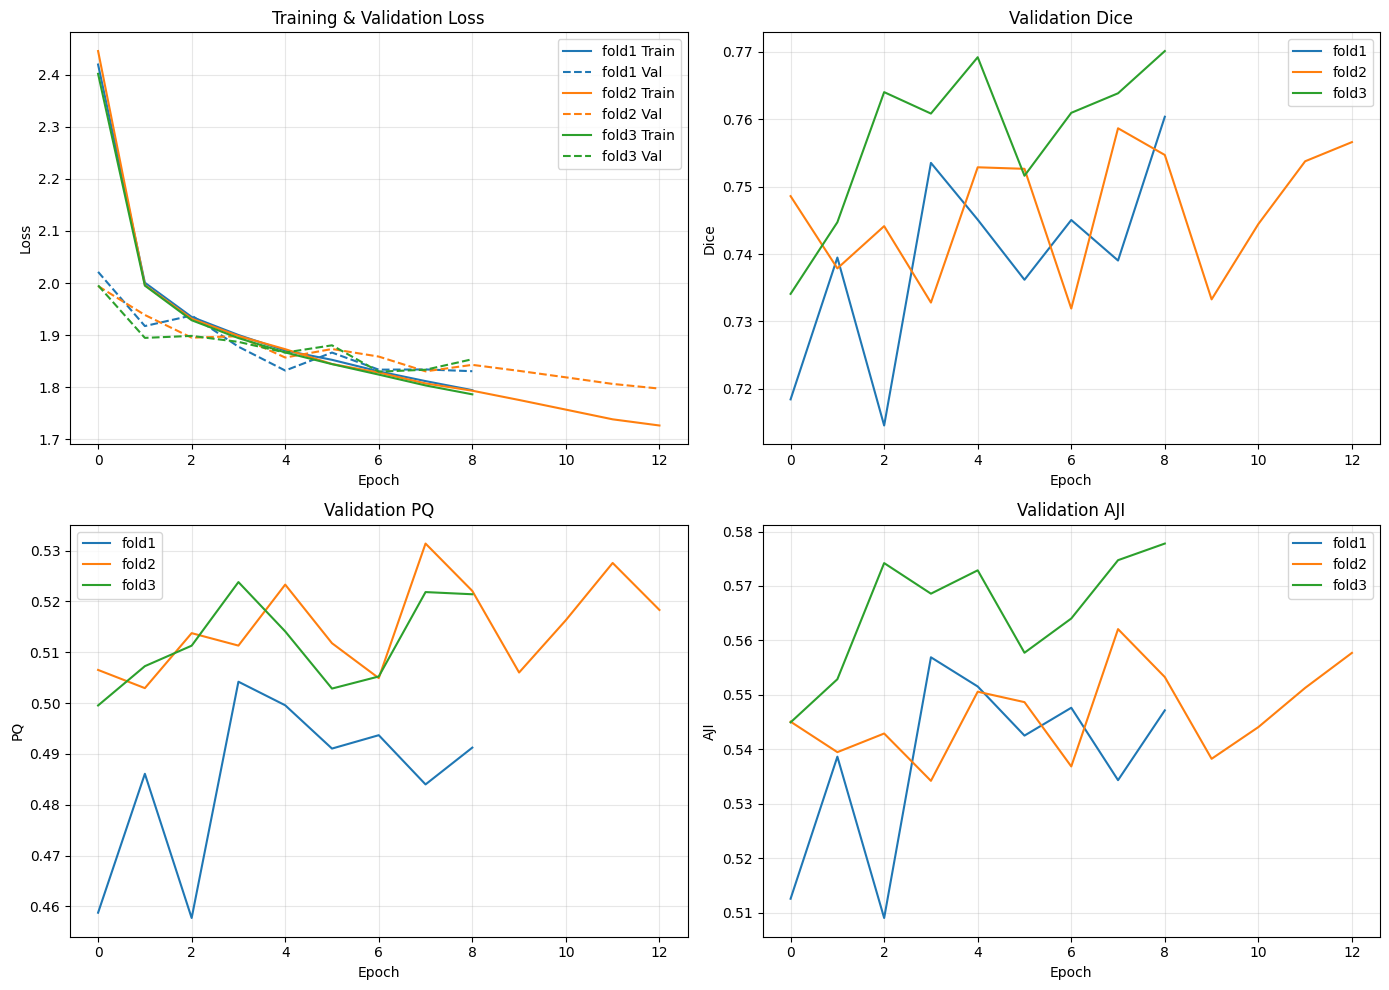


STARTING ZERO-SHOT EVALUATION


UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL numpy.core.multiarray.scalar was not an allowed global by default. Please use `torch.serialization.add_safe_globals([numpy.core.multiarray.scalar])` or the `torch.serialization.safe_globals([numpy.core.multiarray.scalar])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

In [ ]:
# Cell 12: Execute Training (Run this cell to start training)

# ===== TRAINING =====
print("="*60)
print("STARTING HOVERNET 3-FOLD CROSS-VALIDATION TRAINING")
print("="*60)

# Run the 3-fold cross-validation
all_results, all_histories, mean_metrics = run_3fold_cv(config, device)

# Plot training history
plot_training_history(all_histories, save_path=os.path.join(config.results_dir, "training_history.png"))

# # ===== ZERO-SHOT EVALUATION =====
# print("\n" + "="*60)
# print("STARTING ZERO-SHOT EVALUATION")
# print("="*60)

# zero_shot_results = run_zero_shot_evaluation(config, device, fold_idx=1)

# # ===== COMPARISON TABLE =====
# print("\n" + "="*60)
# print("CREATING COMPARISON TABLE")
# print("="*60)

# # Try to find CIPS-Net results
# cipsnet_results_path = os.path.join(config.base_path, "results/cipsnet_text_variants_evaluation/pannuke_results.json")
# create_comparison_table(mean_metrics, cipsnet_results_path)

# print("\n" + "="*60)
# print("TRAINING AND EVALUATION COMPLETE!")
# print("="*60)

In [9]:
# ===== ZERO-SHOT EVALUATION =====
print("\n" + "="*60)
print("STARTING ZERO-SHOT EVALUATION")
print("="*60)

zero_shot_results = run_zero_shot_evaluation(config, device, fold_idx=1)

# Print zero-shot summary
if zero_shot_results:
    print("\n" + "="*60)
    print("ZERO-SHOT EVALUATION SUMMARY")
    print("="*60)
    
    for dataset_name, metrics in zero_shot_results.items():
        print(f"\n{dataset_name}:")
        print(f"  Dice: {metrics.get('dice', 0):.4f} ± {metrics.get('dice_std', 0):.4f}")
        print(f"  AJI: {metrics.get('aji', 0):.4f} ± {metrics.get('aji_std', 0):.4f}")
        print(f"  PQ: {metrics.get('pq', 0):.4f} ± {metrics.get('pq_std', 0):.4f}")

print("\n" + "="*60)
print("ZERO-SHOT EVALUATION COMPLETE!")
print("="*60)


STARTING ZERO-SHOT EVALUATION
Loaded model from /mnt/e3dbc9b9-6856-470d-84b1-ff55921cd906/Datasets/Nikhil/Histopathology_Work/checkpoints/hovernet/hovernet_fold1_best.pth
Model trained for 4 epochs
Loaded 14 CoNSeP Test images

Evaluating CoNSeP (14 images)...


100%|██████████| 14/14 [00:10<00:00,  1.33it/s]



CoNSeP Zero-Shot Results:
  Dice: 0.2769
  AJI: 0.0316
  PQ: 0.0008
Loaded 85 MoNuSAC images

Evaluating MoNuSAC (85 images)...


100%|██████████| 85/85 [00:21<00:00,  4.02it/s]


MoNuSAC Zero-Shot Results:
  Dice: 0.1904
  AJI: 0.0996
  PQ: 0.1003

Results saved to /mnt/e3dbc9b9-6856-470d-84b1-ff55921cd906/Datasets/Nikhil/Histopathology_Work/results/hovernet_pannuke/hovernet_zero_shot_results.json

ZERO-SHOT EVALUATION SUMMARY

CoNSeP:
  Dice: 0.2769 ± 0.1852
  AJI: 0.0316 ± 0.0354
  PQ: 0.0008 ± 0.0022

MoNuSAC:
  Dice: 0.1904 ± 0.2041
  AJI: 0.0996 ± 0.1415
  PQ: 0.1003 ± 0.1431

ZERO-SHOT EVALUATION COMPLETE!


In [10]:
# Cell: Fine-tuning Dataset Classes for CoNSeP and MoNuSAC (CORRECT CLASS MAPPINGS)

class CoNSePTrainDataset(Dataset):
    """CoNSeP dataset for fine-tuning with augmentation.
    
    CoNSeP Classes → HoverNet Classes:
        0: Background → 0: Background
        2: Inflammatory → 2: Inflammatory
        3: Healthy Epithelial → 5: Epithelial
        4: Dysplastic/Malignant → 1: Neoplastic
        5: Fibroblast → 3: Connective
        1,6,7: Other/Muscle/Endothelial → 0: Background (unmapped)
    """
    
    # CORRECT Class mapping: CoNSeP -> HoverNet (PanNuke-based)
    CLASS_MAPPING = {
        0: 0,  # Background -> Background
        2: 2,  # Inflammatory -> Inflammatory
        3: 5,  # Healthy Epithelial -> Epithelial
        4: 1,  # Dysplastic/Malignant -> Neoplastic
        5: 3,  # Fibroblast -> Connective
        # 1, 6, 7 unmapped -> will become 0 (background)
    }
    
    def __init__(self, data_path, config, split='Train', augment=True):
        self.config = config
        self.data_path = data_path
        self.input_shape = config.act_shape
        self.output_shape = config.out_shape
        self.augment = augment
        
        self.images = []
        self.inst_maps = []
        self.type_maps = []
        
        img_dir = os.path.join(data_path, f'{split}/Images')
        label_dir = os.path.join(data_path, f'{split}/Labels')
        
        if not os.path.exists(img_dir):
            print(f"Warning: {img_dir} not found")
            return
        
        for img_name in sorted(os.listdir(img_dir)):
            if not img_name.endswith(('.png', '.jpg', '.tif')):
                continue
            
            img_path = os.path.join(img_dir, img_name)
            label_name = img_name.replace('.png', '.mat').replace('.jpg', '.mat').replace('.tif', '.mat')
            label_path = os.path.join(label_dir, label_name)
            
            if os.path.exists(label_path):
                img = cv2.imread(img_path)
                if img is None:
                    continue
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                
                label_data = sio.loadmat(label_path)
                inst_map = label_data.get('inst_map', np.zeros_like(img[:,:,0]))
                type_map = label_data.get('type_map', np.zeros_like(img[:,:,0]))
                
                # Apply class mapping
                mapped_type = np.zeros_like(type_map)
                for src, dst in self.CLASS_MAPPING.items():
                    mapped_type[type_map == src] = dst
                
                # Extract patches
                patches = self._extract_patches(img, inst_map, mapped_type)
                for patch in patches:
                    self.images.append(patch['image'])
                    self.inst_maps.append(patch['inst_map'])
                    self.type_maps.append(patch['type_map'])
        
        print(f"Loaded {len(self.images)} CoNSeP {split} patches")
    
    def _extract_patches(self, image, inst_map, type_map, stride=128):
        """Extract overlapping patches from large images."""
        patches = []
        H, W = image.shape[:2]
        patch_size = self.input_shape[0]
        
        if H < patch_size or W < patch_size:
            pad_h = max(0, patch_size - H)
            pad_w = max(0, patch_size - W)
            image = np.pad(image, ((0, pad_h), (0, pad_w), (0, 0)), mode='reflect')
            inst_map = np.pad(inst_map, ((0, pad_h), (0, pad_w)), mode='constant')
            type_map = np.pad(type_map, ((0, pad_h), (0, pad_w)), mode='constant')
            H, W = image.shape[:2]
        
        for y in range(0, H - patch_size + 1, stride):
            for x in range(0, W - patch_size + 1, stride):
                img_patch = image[y:y+patch_size, x:x+patch_size]
                inst_patch = inst_map[y:y+patch_size, x:x+patch_size]
                type_patch = type_map[y:y+patch_size, x:x+patch_size]
                
                if np.sum(inst_patch > 0) > 100:
                    patches.append({
                        'image': img_patch,
                        'inst_map': inst_patch.astype(np.int32),
                        'type_map': type_patch.astype(np.int32)
                    })
        
        if len(patches) == 0:
            cy, cx = H // 2, W // 2
            y1 = max(0, cy - patch_size // 2)
            x1 = max(0, cx - patch_size // 2)
            patches.append({
                'image': image[y1:y1+patch_size, x1:x1+patch_size],
                'inst_map': inst_map[y1:y1+patch_size, x1:x1+patch_size].astype(np.int32),
                'type_map': type_map[y1:y1+patch_size, x1:x1+patch_size].astype(np.int32)
            })
        
        return patches
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx].copy()
        inst_map = self.inst_maps[idx].copy()
        type_map = self.type_maps[idx].copy()
        
        if len(inst_map.shape) == 3:
            inst_map = inst_map[:, :, 0]
        if len(type_map.shape) == 3:
            type_map = type_map[:, :, 0]
        
        # Data augmentation
        if self.augment:
            if np.random.random() > 0.5:
                image = np.fliplr(image).copy()
                inst_map = np.fliplr(inst_map).copy()
                type_map = np.fliplr(type_map).copy()
            if np.random.random() > 0.5:
                image = np.flipud(image).copy()
                inst_map = np.flipud(inst_map).copy()
                type_map = np.flipud(type_map).copy()
            
            k = np.random.randint(4)
            if k > 0:
                image = np.rot90(image, k).copy()
                inst_map = np.rot90(inst_map, k).copy()
                type_map = np.rot90(type_map, k).copy()
            
            if np.random.random() > 0.5:
                image = image.astype(np.float32)
                image = image * (0.8 + 0.4 * np.random.random())
                image = np.clip(image, 0, 255).astype(np.uint8)
        
        inst_map = remap_label(inst_map)
        inst_map_crop = cropping_center(inst_map, self.output_shape)
        np_map = (inst_map_crop > 0).astype(np.int32)
        hv_map = gen_instance_hv_map(inst_map_crop)
        type_map_crop = cropping_center(type_map, self.output_shape)
        
        image_tensor = torch.from_numpy(image.astype(np.float32)).permute(2, 0, 1)
        np_tensor = torch.from_numpy(np_map.astype(np.int64))
        hv_tensor = torch.from_numpy(hv_map.astype(np.float32))
        tp_tensor = torch.from_numpy(type_map_crop.astype(np.int64))
        
        return {
            'image': image_tensor,
            'np_map': np_tensor,
            'hv_map': hv_tensor,
            'tp_map': tp_tensor,
        }


class MoNuSACTrainDataset(Dataset):
    """MoNuSAC dataset for fine-tuning with augmentation.
    
    MoNuSAC Classes → HoverNet Classes:
        Epithelial → 5: Epithelial
        Lymphocyte → 2: Inflammatory
        Macrophage → 2: Inflammatory
        Neutrophil → 2: Inflammatory
    """
    
    CLASS_NAME_MAPPING = {
        'Epithelial': 5,   # Epithelial -> Epithelial
        'Lymphocyte': 2,   # Lymphocyte -> Inflammatory
        'Macrophage': 2,   # Macrophage -> Inflammatory
        'Neutrophil': 2,   # Neutrophil -> Inflammatory
    }
    
    def __init__(self, data_path, config, split='Train', augment=True):
        self.config = config
        self.data_path = data_path
        self.input_shape = config.act_shape
        self.output_shape = config.out_shape
        self.augment = augment
        
        self.images = []
        self.inst_maps = []
        self.type_maps = []
        
        split_dir = os.path.join(data_path, split)
        if not os.path.exists(split_dir):
            print(f"Warning: {split_dir} not found")
            return
        
        self._load_monusac_data(split_dir)
        print(f"Loaded {len(self.images)} MoNuSAC {split} patches")
    
    def _load_monusac_data(self, base_dir):
        """Load MoNuSAC data from directory with XML annotations."""
        for patient_dir in sorted(os.listdir(base_dir)):
            patient_path = os.path.join(base_dir, patient_dir)
            if not os.path.isdir(patient_path):
                continue
            
            for f in os.listdir(patient_path):
                if f.endswith(('.tif', '.png', '.jpg')) and not f.endswith('_mask.png'):
                    img_path = os.path.join(patient_path, f)
                    xml_path = img_path.rsplit('.', 1)[0] + '.xml'
                    
                    if os.path.exists(xml_path):
                        try:
                            img = cv2.imread(img_path)
                            if img is None:
                                continue
                            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                            
                            inst_map, type_map = self._parse_xml(xml_path, img.shape[:2])
                            
                            # Extract patches
                            patches = self._extract_patches(img, inst_map, type_map)
                            for patch in patches:
                                self.images.append(patch['image'])
                                self.inst_maps.append(patch['inst_map'])
                                self.type_maps.append(patch['type_map'])
                        except Exception as e:
                            continue
    
    def _parse_xml(self, xml_path, img_shape):
        """Parse MoNuSAC XML annotation file."""
        H, W = img_shape
        inst_map = np.zeros((H, W), dtype=np.int32)
        type_map = np.zeros((H, W), dtype=np.int32)
        
        tree = ET.parse(xml_path)
        root = tree.getroot()
        
        instance_id = 1
        
        for annotation in root.findall('.//Annotation'):
            class_name = None
            for attr in annotation.findall('.//Attribute'):
                name = attr.get('Name')
                if name in self.CLASS_NAME_MAPPING:
                    class_name = name
                    break
            
            if class_name is None:
                continue
            
            pannuke_class = self.CLASS_NAME_MAPPING[class_name]
            
            for region in annotation.findall('.//Region'):
                vertices = region.findall('.//Vertex')
                if len(vertices) < 3:
                    continue
                
                coords = []
                for vertex in vertices:
                    x = float(vertex.get('X'))
                    y = float(vertex.get('Y'))
                    coords.append([int(x), int(y)])
                
                coords = np.array(coords, dtype=np.int32)
                cv2.fillPoly(inst_map, [coords], instance_id)
                cv2.fillPoly(type_map, [coords], pannuke_class)
                instance_id += 1
        
        return inst_map, type_map
    
    def _extract_patches(self, image, inst_map, type_map, stride=128):
        """Extract overlapping patches."""
        patches = []
        H, W = image.shape[:2]
        patch_size = self.input_shape[0]
        
        if H < patch_size or W < patch_size:
            pad_h = max(0, patch_size - H)
            pad_w = max(0, patch_size - W)
            image = np.pad(image, ((0, pad_h), (0, pad_w), (0, 0)), mode='reflect')
            inst_map = np.pad(inst_map, ((0, pad_h), (0, pad_w)), mode='constant')
            type_map = np.pad(type_map, ((0, pad_h), (0, pad_w)), mode='constant')
            H, W = image.shape[:2]
        
        for y in range(0, H - patch_size + 1, stride):
            for x in range(0, W - patch_size + 1, stride):
                img_patch = image[y:y+patch_size, x:x+patch_size]
                inst_patch = inst_map[y:y+patch_size, x:x+patch_size]
                type_patch = type_map[y:y+patch_size, x:x+patch_size]
                
                if np.sum(inst_patch > 0) > 100:
                    patches.append({
                        'image': img_patch,
                        'inst_map': inst_patch.astype(np.int32),
                        'type_map': type_patch.astype(np.int32)
                    })
        
        if len(patches) == 0:
            cy, cx = H // 2, W // 2
            y1 = max(0, cy - patch_size // 2)
            x1 = max(0, cx - patch_size // 2)
            patches.append({
                'image': image[y1:y1+patch_size, x1:x1+patch_size],
                'inst_map': inst_map[y1:y1+patch_size, x1:x1+patch_size].astype(np.int32),
                'type_map': type_map[y1:y1+patch_size, x1:x1+patch_size].astype(np.int32)
            })
        
        return patches
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx].copy()
        inst_map = self.inst_maps[idx].copy()
        type_map = self.type_maps[idx].copy()
        
        if len(inst_map.shape) == 3:
            inst_map = inst_map[:, :, 0]
        if len(type_map.shape) == 3:
            type_map = type_map[:, :, 0]
        
        # Data augmentation
        if self.augment:
            if np.random.random() > 0.5:
                image = np.fliplr(image).copy()
                inst_map = np.fliplr(inst_map).copy()
                type_map = np.fliplr(type_map).copy()
            if np.random.random() > 0.5:
                image = np.flipud(image).copy()
                inst_map = np.flipud(inst_map).copy()
                type_map = np.flipud(type_map).copy()
            
            k = np.random.randint(4)
            if k > 0:
                image = np.rot90(image, k).copy()
                inst_map = np.rot90(inst_map, k).copy()
                type_map = np.rot90(type_map, k).copy()
            
            if np.random.random() > 0.5:
                image = image.astype(np.float32)
                image = image * (0.8 + 0.4 * np.random.random())
                image = np.clip(image, 0, 255).astype(np.uint8)
        
        inst_map = remap_label(inst_map)
        inst_map_crop = cropping_center(inst_map, self.output_shape)
        np_map = (inst_map_crop > 0).astype(np.int32)
        hv_map = gen_instance_hv_map(inst_map_crop)
        type_map_crop = cropping_center(type_map, self.output_shape)
        
        image_tensor = torch.from_numpy(image.astype(np.float32)).permute(2, 0, 1)
        np_tensor = torch.from_numpy(np_map.astype(np.int64))
        hv_tensor = torch.from_numpy(hv_map.astype(np.float32))
        tp_tensor = torch.from_numpy(type_map_crop.astype(np.int64))
        
        return {
            'image': image_tensor,
            'np_map': np_tensor,
            'hv_map': hv_tensor,
            'tp_map': tp_tensor,
        }


# Test the datasets
consep_path = os.path.join(config.base_path, "Histopathology_Datasets_Official/CoNSeP")
monusac_path = os.path.join(config.base_path, "Histopathology_Datasets_Official/MoNuSAC")

print("Testing CoNSeP dataset...")
consep_train = CoNSePTrainDataset(consep_path, config, split='Train', augment=True)
consep_val = CoNSePTrainDataset(consep_path, config, split='Test', augment=False)

print("\nTesting MoNuSAC dataset...")
monusac_train = MoNuSACTrainDataset(monusac_path, config, split='Train', augment=True)
monusac_val = MoNuSACTrainDataset(monusac_path, config, split='Test', augment=False)

print("\nDataset summary:")
print(f"  CoNSeP Train: {len(consep_train)} patches")
print(f"  CoNSeP Val: {len(consep_val)} patches")
print(f"  MoNuSAC Train: {len(monusac_train)} patches")
print(f"  MoNuSAC Val: {len(monusac_val)} patches")

Testing CoNSeP dataset...
Loaded 926 CoNSeP Train patches
Loaded 496 CoNSeP Test patches

Testing MoNuSAC dataset...
Loaded 3803 MoNuSAC Train patches
Loaded 1424 MoNuSAC Test patches

Dataset summary:
  CoNSeP Train: 926 patches
  CoNSeP Val: 496 patches
  MoNuSAC Train: 3803 patches
  MoNuSAC Val: 1424 patches


In [11]:
# Cell: Fine-tuning Functions

def finetune_on_dataset(dataset_name, train_dataset, val_dataset, config, device, 
                        num_epochs=10, lr=1e-5, patience=5, batch_size=2):
    """
    Fine-tune HoverNet on a new dataset starting from PanNuke pretrained weights.
    
    Args:
        dataset_name: Name of dataset ('CoNSeP' or 'MoNuSAC')
        train_dataset: Training dataset
        val_dataset: Validation dataset  
        config: HoverNetConfig
        device: torch device
        num_epochs: Number of fine-tuning epochs
        lr: Learning rate (lower for fine-tuning)
        patience: Early stopping patience
        batch_size: Batch size for training
    """
    print(f"\n{'='*60}")
    print(f"FINE-TUNING ON {dataset_name}")
    print(f"{'='*60}")
    
    # Load pretrained model from PanNuke training
    model = HoVerNet(nr_types=config.nr_types, mode=config.model_mode)
    
    # Load PanNuke pretrained weights
    pretrained_path = os.path.join(config.checkpoint_dir, "hovernet_fold1_best.pth")
    if os.path.exists(pretrained_path):
        checkpoint = torch.load(pretrained_path, map_location=device, weights_only=False)
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"Loaded pretrained weights from {pretrained_path}")
    else:
        print(f"Warning: No pretrained weights found at {pretrained_path}")
        print("Training from scratch...")
    
    model = model.to(device)
    
    # Create data loaders
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory=True,
        drop_last=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )
    
    print(f"Train samples: {len(train_dataset)}")
    print(f"Val samples: {len(val_dataset)}")
    
    # Loss and optimizer (lower LR for fine-tuning)
    loss_weights = {
        'np_bce': 1.0,
        'np_dice': 1.0,
        'hv_mse': 1.0,
        'hv_msge': 1.0,
        'tp_bce': 1.0,
        'tp_dice': 1.0,
    }
    criterion = HoverNetLoss(nr_types=config.nr_types, loss_weights=loss_weights)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    
    # Training history
    history = {
        'train_loss': [], 'val_loss': [],
        'val_dice': [], 'val_aji': [], 'val_pq': []
    }
    
    best_pq = 0.0
    best_epoch = 0
    epochs_without_improvement = 0
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
        for batch in pbar:
            images = batch['image'].to(device)
            targets = {
                'np_map': batch['np_map'].to(device),
                'hv_map': batch['hv_map'].to(device),
                'tp_map': batch['tp_map'].to(device),
            }
            
            optimizer.zero_grad()
            outputs = model(images)
            loss, _ = criterion(outputs, targets)
            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            train_loss += loss.item()
            pbar.set_postfix({'loss': f'{loss.item():.4f}'})
        
        train_loss /= len(train_loader)
        history['train_loss'].append(train_loss)
        
        # Validation
        model.eval()
        val_loss = 0.0
        all_metrics = []
        
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
                images = batch['image'].to(device)
                targets = {
                    'np_map': batch['np_map'].to(device),
                    'hv_map': batch['hv_map'].to(device),
                    'tp_map': batch['tp_map'].to(device),
                }
                
                outputs = model(images)
                loss, _ = criterion(outputs, targets)
                val_loss += loss.item()
                
                # Compute metrics
                results = post_process_batch(outputs)
                
                for i in range(len(results)):
                    pred_inst, pred_type = results[i]
                    true_inst = targets['np_map'][i].cpu().numpy()
                    true_type = targets['tp_map'][i].cpu().numpy()
                    
                    metrics = compute_metrics(
                        pred_inst, pred_type,
                        true_inst, true_type,
                        nr_types=config.nr_types
                    )
                    all_metrics.append(metrics)
        
        val_loss /= len(val_loader)
        history['val_loss'].append(val_loss)
        
        # Aggregate metrics
        val_dice = np.mean([m['dice'] for m in all_metrics])
        val_aji = np.mean([m['aji'] for m in all_metrics])
        val_pq = np.mean([m['pq'] for m in all_metrics])
        
        history['val_dice'].append(val_dice)
        history['val_aji'].append(val_aji)
        history['val_pq'].append(val_pq)
        
        print(f"\nEpoch {epoch+1}/{num_epochs}:")
        print(f"  Train Loss: {train_loss:.4f}")
        print(f"  Val Loss: {val_loss:.4f}")
        print(f"  Val Dice: {val_dice:.4f}, AJI: {val_aji:.4f}, PQ: {val_pq:.4f}")
        
        # Early stopping check
        if val_pq > best_pq:
            best_pq = val_pq
            best_epoch = epoch + 1
            epochs_without_improvement = 0
            
            # Save best model
            save_path = os.path.join(config.checkpoint_dir, f"hovernet_{dataset_name.lower()}_finetuned_best.pth")
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_pq': best_pq,
                'history': history,
            }, save_path)
            print(f"  ✓ New best model saved! (PQ: {best_pq:.4f})")
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"\nEarly stopping triggered after {epoch+1} epochs")
                break
        
        scheduler.step()
    
    # Load best model for final evaluation
    best_path = os.path.join(config.checkpoint_dir, f"hovernet_{dataset_name.lower()}_finetuned_best.pth")
    checkpoint = torch.load(best_path, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    print(f"\nFine-tuning complete!")
    print(f"Best epoch: {best_epoch}")
    print(f"Best PQ: {best_pq:.4f}")
    
    return model, history, best_pq


def evaluate_finetuned_model(model, dataset, config, device, dataset_name):
    """Evaluate fine-tuned model on test set."""
    model.eval()
    all_metrics = []
    
    print(f"\nEvaluating fine-tuned model on {dataset_name} test set...")
    
    with torch.no_grad():
        for idx in tqdm(range(len(dataset))):
            try:
                sample = dataset[idx]
                image = sample['image']
                true_inst = sample['inst_map']
                true_type = sample['type_map']
                
                # Ensure masks are 2D
                if len(true_inst.shape) == 3:
                    true_inst = true_inst[:, :, 0]
                if len(true_type.shape) == 3:
                    true_type = true_type[:, :, 0]
                
                true_inst = np.atleast_2d(true_inst.squeeze())
                true_type = np.atleast_2d(true_type.squeeze())
                
                H, W = image.shape[:2]
                patch_size = config.act_shape[0]
                
                # Pad if needed
                if H < patch_size or W < patch_size:
                    pad_h = max(0, patch_size - H)
                    pad_w = max(0, patch_size - W)
                    image = np.pad(image, ((0, pad_h), (0, pad_w), (0, 0)), mode='reflect')
                    true_inst = np.pad(true_inst, ((0, pad_h), (0, pad_w)), mode='constant')
                    true_type = np.pad(true_type, ((0, pad_h), (0, pad_w)), mode='constant')
                    H, W = image.shape[:2]
                
                # Process
                if H <= patch_size and W <= patch_size:
                    img_tensor = torch.from_numpy(image.astype(np.float32)).permute(2, 0, 1).unsqueeze(0).to(device)
                    outputs = model(img_tensor)
                    results = post_process_batch(outputs)
                    pred_inst, pred_type = results[0]
                    
                    true_inst_crop = cropping_center(true_inst, config.out_shape)
                    true_type_crop = cropping_center(true_type, config.out_shape)
                else:
                    # Resize large images
                    scale = patch_size / max(H, W)
                    new_H, new_W = int(H * scale), int(W * scale)
                    
                    image_resized = cv2.resize(image, (new_W, new_H))
                    pad_h = patch_size - new_H
                    pad_w = patch_size - new_W
                    image_padded = np.pad(image_resized, ((0, pad_h), (0, pad_w), (0, 0)), mode='reflect')
                    
                    img_tensor = torch.from_numpy(image_padded.astype(np.float32)).permute(2, 0, 1).unsqueeze(0).to(device)
                    outputs = model(img_tensor)
                    results = post_process_batch(outputs)
                    pred_inst, pred_type = results[0]
                    
                    true_inst_resized = cv2.resize(true_inst.astype(np.float32), (new_W, new_H), interpolation=cv2.INTER_NEAREST).astype(np.int32)
                    true_type_resized = cv2.resize(true_type.astype(np.float32), (new_W, new_H), interpolation=cv2.INTER_NEAREST).astype(np.int32)
                    
                    true_inst_crop = cropping_center(np.pad(true_inst_resized, ((0, pad_h), (0, pad_w)), mode='constant'), config.out_shape)
                    true_type_crop = cropping_center(np.pad(true_type_resized, ((0, pad_h), (0, pad_w)), mode='constant'), config.out_shape)
                
                metrics = compute_metrics(pred_inst, pred_type, true_inst_crop, true_type_crop, nr_types=config.nr_types)
                all_metrics.append(metrics)
            except Exception as e:
                continue
    
    # Aggregate
    agg_metrics = {}
    if len(all_metrics) > 0:
        for key in all_metrics[0].keys():
            values = [m[key] for m in all_metrics]
            agg_metrics[key] = np.mean(values)
            agg_metrics[f'{key}_std'] = np.std(values)
    
    return agg_metrics


print("Fine-tuning functions defined!")

Fine-tuning functions defined!


In [12]:
# Cell: Run Fine-tuning on CoNSeP and MoNuSAC

import gc

# Clear GPU memory first
torch.cuda.empty_cache()
gc.collect()
print(f"GPU Memory before fine-tuning:")
print(f"  Allocated: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
print(f"  Cached: {torch.cuda.memory_reserved() / 1e9:.2f} GB")

# Store all results
all_finetune_results = {}

# Use smaller batch size for fine-tuning to avoid OOM
finetune_batch_size = 2

# ===== Fine-tune on CoNSeP =====
consep_path = os.path.join(config.base_path, "Histopathology_Datasets_Official/CoNSeP")

if os.path.exists(consep_path):
    print("\n" + "="*60)
    print("PREPARING CoNSeP DATASET")
    print("="*60)
    
    # Load CoNSeP train and test sets
    consep_train = CoNSePTrainDataset(consep_path, config, split='Train', augment=True)
    consep_val = CoNSePTrainDataset(consep_path, config, split='Test', augment=False)
    
    if len(consep_train) > 0:
        # Fine-tune
        consep_model, consep_history, consep_best_pq = finetune_on_dataset(
            dataset_name='CoNSeP',
            train_dataset=consep_train,
            val_dataset=consep_val,
            config=config,
            device=device,
            num_epochs=15,
            lr=1e-5,
            patience=5,
            batch_size=finetune_batch_size
        )
        
        # Evaluate on test set using zero-shot dataset class
        consep_test_dataset = CoNSePDataset(consep_path, config, split='Test')
        consep_finetuned_metrics = evaluate_finetuned_model(
            consep_model, consep_test_dataset, config, device, 'CoNSeP'
        )
        
        all_finetune_results['CoNSeP'] = {
            'finetuned': consep_finetuned_metrics,
            'zero_shot': zero_shot_results.get('CoNSeP', {}),
            'history': consep_history
        }
        
        print(f"\nCoNSeP Fine-tuned Results:")
        print(f"  Dice: {consep_finetuned_metrics.get('dice', 0):.4f}")
        print(f"  AJI: {consep_finetuned_metrics.get('aji', 0):.4f}")
        print(f"  PQ: {consep_finetuned_metrics.get('pq', 0):.4f}")
        
        # Clean up
        del consep_model, consep_train, consep_val
        torch.cuda.empty_cache()
        gc.collect()
else:
    print(f"CoNSeP dataset not found at {consep_path}")

# ===== Fine-tune on MoNuSAC =====
monusac_path = os.path.join(config.base_path, "Histopathology_Datasets_Official/MoNuSAC")

if os.path.exists(monusac_path):
    print("\n" + "="*60)
    print("PREPARING MoNuSAC DATASET")
    print("="*60)
    
    # Load MoNuSAC train and test sets (MoNuSAC uses 'Train' and 'Test' folders)
    monusac_train = MoNuSACTrainDataset(monusac_path, config, split='Train', augment=True)
    monusac_val = MoNuSACTrainDataset(monusac_path, config, split='Test', augment=False)
    
    if len(monusac_train) > 0:
        # Fine-tune
        monusac_model, monusac_history, monusac_best_pq = finetune_on_dataset(
            dataset_name='MoNuSAC',
            train_dataset=monusac_train,
            val_dataset=monusac_val,
            config=config,
            device=device,
            num_epochs=15,
            lr=1e-5,
            patience=5,
            batch_size=finetune_batch_size
        )
        
        # Evaluate on test set using zero-shot dataset class
        monusac_test_dataset = MoNuSACDataset(monusac_path, config, split='Test')
        monusac_finetuned_metrics = evaluate_finetuned_model(
            monusac_model, monusac_test_dataset, config, device, 'MoNuSAC'
        )
        
        all_finetune_results['MoNuSAC'] = {
            'finetuned': monusac_finetuned_metrics,
            'zero_shot': zero_shot_results.get('MoNuSAC', {}),
            'history': monusac_history
        }
        
        print(f"\nMoNuSAC Fine-tuned Results:")
        print(f"  Dice: {monusac_finetuned_metrics.get('dice', 0):.4f}")
        print(f"  AJI: {monusac_finetuned_metrics.get('aji', 0):.4f}")
        print(f"  PQ: {monusac_finetuned_metrics.get('pq', 0):.4f}")
        
        # Clean up
        del monusac_model, monusac_train, monusac_val
        torch.cuda.empty_cache()
        gc.collect()
else:
    print(f"MoNuSAC dataset not found at {monusac_path}")

print("\n" + "="*60)
print("FINE-TUNING COMPLETE!")
print("="*60)

GPU Memory before fine-tuning:
  Allocated: 0.17 GB
  Cached: 0.23 GB

PREPARING CoNSeP DATASET
Loaded 926 CoNSeP Train patches
Loaded 496 CoNSeP Test patches

FINE-TUNING ON CoNSeP
Loaded pretrained weights from /mnt/e3dbc9b9-6856-470d-84b1-ff55921cd906/Datasets/Nikhil/Histopathology_Work/checkpoints/hovernet/hovernet_fold1_best.pth
Train samples: 926
Val samples: 496


Epoch 1/15 [Val]: 100%|██████████| 248/248 [00:44<00:00,  5.61it/s]



Epoch 1/15:
  Train Loss: 2.4567
  Val Loss: 2.4216
  Val Dice: 0.6899, AJI: 0.0894, PQ: 0.0077
  ✓ New best model saved! (PQ: 0.0077)


Epoch 2/15 [Val]: 100%|██████████| 248/248 [00:45<00:00,  5.47it/s]



Epoch 2/15:
  Train Loss: 2.3696
  Val Loss: 2.4070
  Val Dice: 0.6863, AJI: 0.0946, PQ: 0.0085
  ✓ New best model saved! (PQ: 0.0085)


Epoch 3/15 [Val]: 100%|██████████| 248/248 [00:46<00:00,  5.29it/s]



Epoch 3/15:
  Train Loss: 2.3074
  Val Loss: 2.3988
  Val Dice: 0.6951, AJI: 0.0911, PQ: 0.0078


Epoch 4/15 [Val]: 100%|██████████| 248/248 [00:46<00:00,  5.28it/s]



Epoch 4/15:
  Train Loss: 2.2878
  Val Loss: 2.3820
  Val Dice: 0.6916, AJI: 0.0915, PQ: 0.0070


Epoch 5/15 [Val]: 100%|██████████| 248/248 [00:45<00:00,  5.42it/s]



Epoch 5/15:
  Train Loss: 2.2796
  Val Loss: 2.3726
  Val Dice: 0.6902, AJI: 0.0933, PQ: 0.0073


Epoch 6/15 [Val]: 100%|██████████| 248/248 [00:45<00:00,  5.46it/s]



Epoch 6/15:
  Train Loss: 2.2461
  Val Loss: 2.3637
  Val Dice: 0.6909, AJI: 0.0930, PQ: 0.0082


Epoch 7/15 [Val]: 100%|██████████| 248/248 [00:46<00:00,  5.37it/s]



Epoch 7/15:
  Train Loss: 2.2423
  Val Loss: 2.3785
  Val Dice: 0.6777, AJI: 0.0917, PQ: 0.0083

Early stopping triggered after 7 epochs

Fine-tuning complete!
Best epoch: 2
Best PQ: 0.0085
Loaded 14 CoNSeP Test images

Evaluating fine-tuned model on CoNSeP test set...


100%|██████████| 14/14 [00:07<00:00,  1.81it/s]



CoNSeP Fine-tuned Results:
  Dice: 0.1816
  AJI: 0.0320
  PQ: 0.0034

PREPARING MoNuSAC DATASET
Loaded 3803 MoNuSAC Train patches
Loaded 1424 MoNuSAC Test patches

FINE-TUNING ON MoNuSAC
Loaded pretrained weights from /mnt/e3dbc9b9-6856-470d-84b1-ff55921cd906/Datasets/Nikhil/Histopathology_Work/checkpoints/hovernet/hovernet_fold1_best.pth
Train samples: 3803
Val samples: 1424


Epoch 1/15 [Val]: 100%|██████████| 712/712 [02:17<00:00,  5.19it/s]



Epoch 1/15:
  Train Loss: 2.1982
  Val Loss: 2.0094
  Val Dice: 0.7582, AJI: 0.0678, PQ: 0.0022
  ✓ New best model saved! (PQ: 0.0022)


Epoch 2/15 [Val]: 100%|██████████| 712/712 [02:15<00:00,  5.24it/s]



Epoch 2/15:
  Train Loss: 2.0211
  Val Loss: 1.9722
  Val Dice: 0.7589, AJI: 0.0702, PQ: 0.0025
  ✓ New best model saved! (PQ: 0.0025)


Epoch 3/15 [Val]: 100%|██████████| 712/712 [02:19<00:00,  5.12it/s]



Epoch 3/15:
  Train Loss: 1.9633
  Val Loss: 1.9996
  Val Dice: 0.7453, AJI: 0.0705, PQ: 0.0027
  ✓ New best model saved! (PQ: 0.0027)


Epoch 4/15 [Val]: 100%|██████████| 712/712 [02:41<00:00,  4.42it/s]



Epoch 4/15:
  Train Loss: 1.9211
  Val Loss: 1.9741
  Val Dice: 0.7491, AJI: 0.0708, PQ: 0.0026


Epoch 5/15 [Val]: 100%|██████████| 712/712 [02:28<00:00,  4.81it/s]



Epoch 5/15:
  Train Loss: 1.8895
  Val Loss: 1.9776
  Val Dice: 0.7417, AJI: 0.0731, PQ: 0.0030
  ✓ New best model saved! (PQ: 0.0030)


Epoch 6/15 [Val]: 100%|██████████| 712/712 [02:18<00:00,  5.14it/s]



Epoch 6/15:
  Train Loss: 1.8645
  Val Loss: 1.9853
  Val Dice: 0.7289, AJI: 0.0716, PQ: 0.0024


Epoch 7/15 [Val]: 100%|██████████| 712/712 [02:26<00:00,  4.87it/s]



Epoch 7/15:
  Train Loss: 1.8450
  Val Loss: 1.9741
  Val Dice: 0.7492, AJI: 0.0717, PQ: 0.0024


Epoch 8/15 [Val]: 100%|██████████| 712/712 [02:18<00:00,  5.15it/s]



Epoch 8/15:
  Train Loss: 1.8236
  Val Loss: 1.9908
  Val Dice: 0.7557, AJI: 0.0709, PQ: 0.0028


Epoch 9/15 [Val]: 100%|██████████| 712/712 [02:16<00:00,  5.22it/s]



Epoch 9/15:
  Train Loss: 1.8124
  Val Loss: 2.0056
  Val Dice: 0.7424, AJI: 0.0719, PQ: 0.0028


Epoch 10/15 [Val]: 100%|██████████| 712/712 [02:16<00:00,  5.20it/s]



Epoch 10/15:
  Train Loss: 1.8019
  Val Loss: 1.9775
  Val Dice: 0.7438, AJI: 0.0715, PQ: 0.0026

Early stopping triggered after 10 epochs

Fine-tuning complete!
Best epoch: 5
Best PQ: 0.0030
Loaded 85 MoNuSAC images

Evaluating fine-tuned model on MoNuSAC test set...


100%|██████████| 85/85 [00:24<00:00,  3.52it/s]



MoNuSAC Fine-tuned Results:
  Dice: 0.3046
  AJI: 0.1411
  PQ: 0.1446

FINE-TUNING COMPLETE!


In [13]:
# Cell: Create Comparison Tables and Save Results

import pandas as pd
from datetime import datetime

def create_full_comparison_table(zero_shot_results, finetune_results):
    """Create comprehensive comparison table."""
    
    print("\n" + "="*80)
    print("COMPREHENSIVE RESULTS COMPARISON - HoverNet")
    print("="*80)
    
    # Zero-shot vs Fine-tuned comparison
    print("\n" + "-"*80)
    print("ZERO-SHOT vs FINE-TUNED PERFORMANCE")
    print("-"*80)
    
    header = f"{'Dataset':<15} {'Setting':<15} {'Dice':<15} {'AJI':<15} {'PQ':<15}"
    print(header)
    print("-"*75)
    
    for dataset_name in ['CoNSeP', 'MoNuSAC']:
        # Zero-shot results
        if dataset_name in zero_shot_results:
            zs = zero_shot_results[dataset_name]
            zs_dice = f"{zs.get('dice', 0):.4f}±{zs.get('dice_std', 0):.4f}"
            zs_aji = f"{zs.get('aji', 0):.4f}±{zs.get('aji_std', 0):.4f}"
            zs_pq = f"{zs.get('pq', 0):.4f}±{zs.get('pq_std', 0):.4f}"
            print(f"{dataset_name:<15} {'Zero-Shot':<15} {zs_dice:<15} {zs_aji:<15} {zs_pq:<15}")
        
        # Fine-tuned results
        if dataset_name in finetune_results:
            ft = finetune_results[dataset_name].get('finetuned', {})
            ft_dice = f"{ft.get('dice', 0):.4f}±{ft.get('dice_std', 0):.4f}"
            ft_aji = f"{ft.get('aji', 0):.4f}±{ft.get('aji_std', 0):.4f}"
            ft_pq = f"{ft.get('pq', 0):.4f}±{ft.get('pq_std', 0):.4f}"
            print(f"{'':<15} {'Fine-tuned':<15} {ft_dice:<15} {ft_aji:<15} {ft_pq:<15}")
            
            # Improvement
            if dataset_name in zero_shot_results:
                zs = zero_shot_results[dataset_name]
                dice_imp = ft.get('dice', 0) - zs.get('dice', 0)
                aji_imp = ft.get('aji', 0) - zs.get('aji', 0)
                pq_imp = ft.get('pq', 0) - zs.get('pq', 0)
                print(f"{'':<15} {'Improvement':<15} {f'+{dice_imp:.4f}' if dice_imp >= 0 else f'{dice_imp:.4f}':<15} {f'+{aji_imp:.4f}' if aji_imp >= 0 else f'{aji_imp:.4f}':<15} {f'+{pq_imp:.4f}' if pq_imp >= 0 else f'{pq_imp:.4f}':<15}")
        
        print()
    
    print("="*80)
    
    return None


# Create comparison table
if 'all_finetune_results' in dir() and len(all_finetune_results) > 0:
    create_full_comparison_table(zero_shot_results, all_finetune_results)
else:
    print("No fine-tuning results available yet. Run fine-tuning first.")

# Save all results to JSON
results_to_save = {
    'zero_shot': zero_shot_results,
    'finetuned': {},
    'timestamp': datetime.now().isoformat(),
    'model': 'HoverNet',
    'pretrained_on': 'PanNuke'
}

if 'all_finetune_results' in dir():
    for dataset_name, data in all_finetune_results.items():
        results_to_save['finetuned'][dataset_name] = {
            'metrics': data.get('finetuned', {}),
            'best_val_pq': data.get('history', {}).get('val_pq', [])[-1] if data.get('history', {}).get('val_pq', []) else 0
        }

results_file = os.path.join(config.results_dir, "hovernet_complete_results.json")
with open(results_file, 'w') as f:
    # Convert numpy values to float for JSON serialization
    def convert(obj):
        if isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        elif isinstance(obj, dict):
            return {k: convert(v) for k, v in obj.items()}
        elif isinstance(obj, list):
            return [convert(i) for i in obj]
        return obj
    
    json.dump(convert(results_to_save), f, indent=2)

print(f"\nAll results saved to {results_file}")
print("\n" + "="*60)
print("HOVERNET EXPERIMENT COMPLETE!")
print("="*60)


COMPREHENSIVE RESULTS COMPARISON - HoverNet

--------------------------------------------------------------------------------
ZERO-SHOT vs FINE-TUNED PERFORMANCE
--------------------------------------------------------------------------------
Dataset         Setting         Dice            AJI             PQ             
---------------------------------------------------------------------------
CoNSeP          Zero-Shot       0.2769±0.1852   0.0316±0.0354   0.0008±0.0022  
                Fine-tuned      0.1816±0.1257   0.0320±0.0306   0.0034±0.0053  
                Improvement     -0.0953         +0.0004         +0.0025        

MoNuSAC         Zero-Shot       0.1904±0.2041   0.0996±0.1415   0.1003±0.1431  
                Fine-tuned      0.3046±0.2274   0.1411±0.1896   0.1446±0.1991  
                Improvement     +0.1142         +0.0414         +0.0443        


All results saved to /mnt/e3dbc9b9-6856-470d-84b1-ff55921cd906/Datasets/Nikhil/Histopathology_Work/results/hovernet_p